In [542]:
 #
 #                             _ooOoo_
 #                            o8888888o
 #                            88" . "88
 #                            (| -_- |)
 #                            O\  =  /O
 #                         ____/`---'\____
 #                       .'  \\|     |//  `.
 #                      /  \\|||  :  |||//  \
 #                     /  _||||| -:- |||||-  \
 #                     |   | \\\  -  /// |   |
 #                     | \_|  ''\---/''  |   |
 #                     \  .-\__  `-`  ___/-. /
 #                   ___`. .'  /--.--\  `. . __
 #                ."" '<  `.___\_<|>_/___.'  >'"".
 #               | | :  `- \`.;`\ _ /`;.`/ - ` : | |
 #               \  \ `-.   \_ __\ /__ _/   .-` /  /
 #          ======`-.____`-.___\_____/___.-`____.-'======
 #                             `=---='
 #          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 #                     佛祖保佑        永无BUG
 #          --------------------- 

In [543]:
import os
import re
import math
import time
import copy
import graphviz
import scikitplot as skplt
import pandas as pd
import numpy as np
import pydotplus
import warnings
import seaborn as sns
import xgboost as xgb
from scipy.stats import mode
import scorecardpy as sc
import plotly_express as px
import plotly.offline as py
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import Image
from pyecharts import Overlap, Line, Bar, Scatter
from sklearn.externals import joblib
import sklearn.preprocessing as preprocessing
from sklearn import metrics, cross_validation
from sklearn2pmml import sklearn2pmml, PMMLPipeline
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, StratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
from sklearn.preprocessing import PolynomialFeatures

os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

In [544]:
def data_desc(df_table):
    t = []
    n = df_table.shape[0]
    for vals in df_table.columns.values.tolist():
        n_dtype = df_table[vals].dtype  #变量类型
        #         n=df_table[vals].count() #变量个数
        n_distinct = df_table[vals].drop_duplicates().count()  #变量去重个数
        n_miss = sum(pd.isnull(df_table[vals]))  #缺失值个数
        pct_miss = np.round(n_miss * 100 / n, 2)  #缺失比例

        if df_table[vals].dtype != 'object':
            n_min = df_table[vals].min()  #最小值
            n_max = df_table[vals].max()  #最大值
            n_mean = df_table[vals].mean()
            n_std = df_table[vals].std()
            q = stats.scoreatpercentile(df_table[vals].dropna(),
                                        [5, 25, 50, 75, 95])  #分位数
        else:
            n_min = np.nan
            n_max = np.nan
            n_mean = np.nan
            n_std = np.nan
            q = [np.nan, np.nan, np.nan, np.nan, np.nan]
        q_low = q[0] - 1.5 * (q[3] - q[1])  #75分位数-25分位数（异常值下界）
        q_upper = q[4] + 1.5 * (q[3] - q[1])  #75分位数-25分位数（异常值上界）
        t.append(
            (vals, n_dtype, n, n_distinct, n_miss, pct_miss, n_min, n_max,
             n_mean,n_std,q[0], q[1], q[2], q[3], q[4],
             (df_table[vals] < q_low).sum() + (df_table[vals] > q_upper).sum(),
             df_table.loc[(df_table[vals] > q_upper) |
                          (df_table[vals] < q_low)].index.tolist()[0:3]))
    colnums = [
        'colums', 'n_dtype', 'n_num', 'n_distinct', 'n_miss', 'pct_miss',
        'n_min', 'n_max', 'n_mean','n_std', 'q_5', 'q_25', 'q_50', 'q_75', 'q_95',
        'n_outliers', 'outliers_index'
    ]
    df_table1 = pd.DataFrame(t, columns=colnums)
    return df_table1


def var_freq(input_data, var, tag, bins):  #单变量可视化
    #input_data 输入数据集；var需要分析变量；tag目标变量;bins为分段数或手工分段list
    input_data['new_tag'] = np.where(input_data['%s' % tag] == 1, 1, 0)
    if input_data['%s' % var].dtypes != np.object and input_data[
            '%s' % var].drop_duplicates().count() > 10:  #数值型且变量类型大于10的变量执行以下代码
        if isinstance(bins, int):
            labels = [i for i in range(0, bins)]
        else:
            labels = [i for i in range(0, len(bins) - 1)]
        cut_1 = pd.cut(
            input_data['%s' % var].tolist(), bins=bins).astype(str)  #变量等宽分组十等份
        cut_2 = pd.cut(
            input_data['%s' % var].tolist(), bins=bins, labels=labels).astype(str)  #变量等宽分组十等份并且记录顺序
        #         cut=[j+'_'+i for i,j in zip(cut_1,cut_2)]
        cat = pd.DataFrame({'%s_gap' % var: cut_1})
        input_data = pd.merge(
            input_data, cat, left_index=True, right_index=True)  #分组变量与原表组合
        input_data['labels'] = cut_2.astype(float)  #引入labels变量主要是为了解决字符变量排序问题
        df_groupby = input_data.fillna(-999).groupby(
            ['labels', '%s_gap' % var])['PassengerId', 'new_tag'].agg({
                'PassengerId': ['count'],
                'new_tag':'sum'
            }).reset_index()
    else:
        input_data['labels'] = input_data['%s' % var]
        df_groupby = input_data.fillna(-999).groupby(
            ['labels', '%s' % var])['PassengerId', 'new_tag'].agg({
                'PassengerId': ['count'],
                'new_tag':'sum'
            }).reset_index()
    var_name = df_groupby.columns.values.tolist()
    df_groupby.drop(var_name[0], inplace=True, axis=1)  #排序完成，删除labels变量
    input_data.drop(['labels', 'new_tag'], axis=1, inplace=True)

    #####计算各个指标
    df_groupby['pct_all_user_sum'] = round(
        df_groupby[var_name[2]] * 100 / (df_groupby[var_name[2]].sum()), 2)
    df_groupby['pct_good_user_sum'] = round(
        df_groupby[var_name[3]] * 100 / (df_groupby[var_name[3]].sum()), 2)
    df_groupby['pct_good_user'] = round(
        df_groupby[var_name[3]] * 100 / df_groupby[var_name[2]], 2)
    df_groupby['woe'] = round(
        ((df_groupby[var_name[3]] / df_groupby[var_name[3]].sum()) / (
            (df_groupby[var_name[2]] - df_groupby[var_name[3]]) /
            (df_groupby[var_name[2]] - df_groupby[var_name[3]]).sum())
         ).apply(lambda x: math.log(x) if x > 0 else 0), 3)
    df_groupby['iv'] =((df_groupby[var_name[3]]/df_groupby[var_name[3]].sum())-((df_groupby[var_name[2]]-df_groupby[var_name[3]])/(df_groupby[var_name[2]]-df_groupby[var_name[3]]).sum()))\
                     *((df_groupby[var_name[3]]/df_groupby[var_name[3]].sum())/((df_groupby[var_name[2]]-df_groupby[var_name[3]])/(df_groupby[var_name[2]]-df_groupby[var_name[3]]).sum())).\
                        apply(lambda x: math.log(x) if x>0 else 0)
    df_groupby['iv_sum'] = df_groupby['iv'].apply(lambda x: x if x != float(
        'inf') else 0).cumsum(axis=0)

    #####绘图部分
    var_name = df_groupby.columns.values.tolist()
    bar = Bar(title='%s' % var_name[0][0])
    bar.add(
        '用户数',
        df_groupby[var_name[0]],
        df_groupby[var_name[1]],
        is_lable_show=True,
        is_datazoom_show=True,
        datazoom_range=[0, 100])
    line = Line()
    line.add(
        '占比',
        df_groupby[var_name[0]],
        df_groupby[var_name[5]],
        is_lable_show=True,
        is_smooth=True)
    overlap = Overlap(width=1200, height=600)
    overlap.add(bar)
    overlap.add(line, is_add_yaxis=True, yaxis_index=1)
    overlap.render('./泰坦尼克/%s_分布.html' % var_name[0][0])
    return df_groupby


def var_freq_2(put_data, var1, var2, tag):  #var1与var2两个变量关于tag的散点图
    #put_data输入数据集，var1,var2为需分析的两个变量，tag为目标变量
    flag = np.unique(put_data['%s' % tag])
    colors = [plt.cm.tab10(i / float(len(flag) - 1)) for i in range(len(flag))]
    # Draw Plot for Each Category
    plt.figure(figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')

    for i, category in enumerate(flag):
        plt.scatter(
            '%s' % var1,
            '%s' % var2,
            data=put_data.loc[put_data['%s' % tag] == category, :],
            s=2,
            cmap=colors[i],
            label=str(category))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('%s' % var1)
    plt.ylabel('%s' % var2)
    plt.title("%(var1)s&&%(var2)s" % {'var1': var1, 'var2': var2}, fontsize=22)
    plt.legend(fontsize=12)
    plt.savefig('./泰坦尼克/%(var1)s&&%(var2)s.png' % {'var1': var1, 'var2': var2})
    plt.show()


def var_astype(data, var):  #将离散变量转换成数值变量(变量本身无序：如性别)
    lable = data[var].unique().tolist()
    data[var] = data[var].apply(lambda x: lable.index(x))  #将离散变量转换成数值变量


def plot_learning_curve(estimator,x,y,title,ylim=None,n_jobs=1,train_sizes=np.linspace(0.1, 1, 5),
                        cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('train examples')
    plt.ylabel('score')
    train_sizes,train_score,test_score=learning_curve(estimator,x,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    train_scores_mean = np.mean(train_score, axis=1)
    train_scores_std = np.std(train_score, axis=1)
    test_scores_mean = np.mean(test_score, axis=1)
    test_scores_std = np.std(test_score, axis=1)
    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,color='r')
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='trains_score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='test_score')
    plt.legend(loc='best')
    return plt


def polynomial_model(degree, **kwarg):  #LR增加二项式特征
    polynomial_Features = PolynomialFeatures(degree=degree, include_bias=False)
    Logistic_Regression = LogisticRegression()
    pipeline = Pipeline([('polynomial_Features', polynomial_Features),
                         ('Logistic_Regression', Logistic_Regression)])
    return pipeline


# PassengerId: 乘客的id
# Survival: 是否幸存 0 = No, 1 = Yes
# Pclass: 舱位 class 1 = 1st, 2 = 2nd, 3 = 3rd
# Name: 姓名
# Sex: 性别
# Age: 年龄
# SibSp: 船上兄弟姐妹以及配偶的个数
# Parch: 船上父母以及者子女的个数
# Ticket: 船票号码
# Fare: 票价
# Cabin: 船舱号码
# Embarked: 登船码头 C = Cherbourg, Q = Queenstown, S = Southampton

In [592]:
#数据读取查看基本特征
warnings.filterwarnings("ignore") #忽略告警信息
train_data = pd.read_csv('./file/train.csv')
validation_data = pd.read_csv('./file/test.csv')
# concat_data=pd.concat([train_data,validation_data])
concat_data=pd.concat(objs=[train_data, validation_data], axis=0).reset_index(drop=True)
pd.set_option('display.max_columns', 100)  ##设置显示列数
pd.set_option('precision', 2)  ##设置小数点位数
pd.set_option('max_colwidth', 1500)  ##设置列长度
concat_data.head(10)
# concat_data[concat_data.index==5]
# data_desc(concat_data)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.25,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.28,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.92,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.10,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.05,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.46,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.86,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.07,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.13,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.07,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


Survived       1.00e+00
Pclass         3.38e-01
Fare           2.57e-01
Parch          8.16e-02
Age            7.72e-02
SibSp          3.53e-02
PassengerId    5.01e-03
Name: Survived, dtype: float64


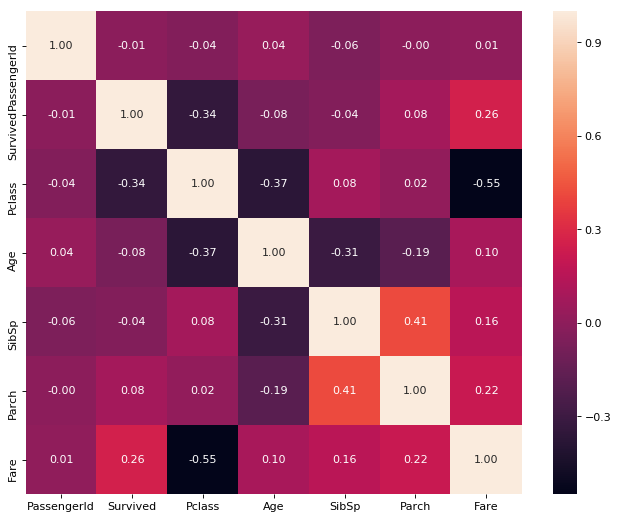

In [548]:
#####变量之间相关性
default_matrix = train_data.corr()
print(abs(default_matrix['Survived']).sort_values(ascending=False)) #与Survived相关性大小
ax=plt.figure(figsize=(10, 8), dpi=80, edgecolor='k').add_subplot(1,1,1)
sns.heatmap(train_data.corr(),annot=True,cbar=True,fmt = ".2f")

In [27]:
####初步单变量分析
data_col = train_data.columns.values.tolist()
for value in data_col:
    var_freq(train_data, value, "Survived", 100)
#     var_freq(train_data, 'Age', "Survived",[-999, 0, 10, 16, 20, 25, 30, 35, 40, 45, 50, 60, 100, 999])
    var_freq(train_data, 'Fare', "Survived",
             [-999] + [i for i in range(0, 100, 10)] + [200, 300, 400, 999])

train_data.drop(['new_tag'], axis=1,inplace=True)  #函数中明明删除了new_tag，但结果表中还又存在new_tag，这个问题待解决

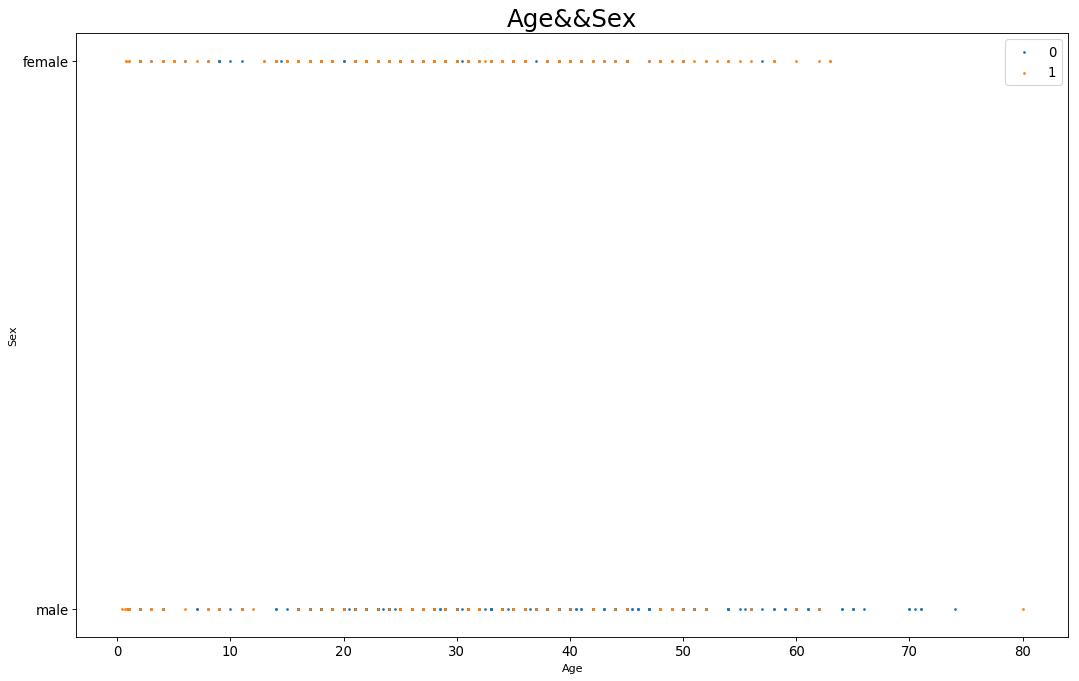

In [11]:
# ##初步双变量分析
# for i,var in enumerate(data_col):
#     for j in range(0,i):
#         var_freq_2(train_data,var,data_col[j],'Survived')

var_freq_2(train_data,'Age','Sex','Survived')

# data0=copy.deepcopy(train_data)
# data0['age_gap']=pd.cut(data0['Age'],[-999, 0, 10, 16, 20, 25, 30, 35, 40, 45, 50, 60, 100, 999]).astype(str)
# data1=data0[train_data['Survived']==1].groupby(['Sex','age_gap'])['PassengerId'].agg('count').reset_index()
# data2=data0.groupby(['Sex','age_gap'])['PassengerId'].agg('count').reset_index()
# data3=pd.merge(data1,data2,on=['Sex','age_gap'],how='right').sort_values('age_gap')
# data3['pct_PassengerId']=data3['PassengerId_x']/data3['PassengerId_y']

# px.line(data3,x='age_gap',y='pct_PassengerId',color='Sex')
# data3

In [593]:
########### Fare 变量处理
concat_data['group_ticket'] =concat_data.groupby(['Ticket'])['PassengerId'].transform('count')
concat_data['avg_fare']=concat_data['Fare']/concat_data['group_ticket']
##对Fare=0的值用当前仓位票价均值填充
# concat_data_train=concat_data.loc[~concat_data['Survived'].isnull()]
# concat_data_test=concat_data.loc[concat_data['Survived'].isnull()]
Pclass_mean_fare_unmiss=concat_data[concat_data['avg_fare']>0].groupby(['Pclass'])['avg_fare'].mean()

# Pclass_1_mean_fare_unmiss=concat_data_train[concat_data_train['Fare']>0].groupby(by=concat_data_train['Pclass'])['avg_fare'].mean().get([1]).values[0]
# Pclass_2_mean_fare_unmiss=concat_data_train[concat_data_train['Fare']>0].groupby(by=concat_data_train['Pclass'])['avg_fare'].mean().get([2]).values[0]
# Pclass_3_mean_fare_unmiss=concat_data_train[concat_data_train['Fare']>0].groupby(by=concat_data_train['Pclass'])['avg_fare'].mean().get([3]).values[0]

def fare_miss_replace(df):
    if df['Pclass']==1 and (df['Fare']==0 or pd.isnull(df['Fare'])):
        return Pclass_mean_fare_unmiss[1]
    elif df['Pclass']==2 and (df['Fare']==0 or pd.isnull(df['Fare'])):
        return Pclass_mean_fare_unmiss[2]
    elif df['Pclass']==3 and (df['Fare']==0 or pd.isnull(df['Fare'])):
        return Pclass_mean_fare_unmiss[3]
    else:
        return df['avg_fare']
    
concat_data['avg_fare'] = concat_data.apply(fare_miss_replace,axis=1)
concat_data.loc[concat_data['Fare'].isnull(),'Fare']=concat_data.loc[concat_data['Fare'].isnull(),'avg_fare']
concat_data['avg_fare_log']=concat_data['avg_fare'].map(lambda i:np.log(i) if i>0 else 0) 
concat_data['fare_log']=concat_data['Fare'].map(lambda i:np.log(i) if i>0 else 0) 
#用avg_fare替代确实Fare

# fare_bins=[min(concat_data['avg_fare']),9,12,24,max(concat_data['avg_fare'])]
# concat_data['avg_fare_bin'] = pd.cut(concat_data['avg_fare'],fare_bins).astype(str)


data_desc(concat_data)
# concat_data.head(10)
var_freq(concat_data[~concat_data['Survived'].isnull()], 'Fare', "Survived", 10)


,Fare_gap,PassengerId,new_tag,pct_all_user_sum,pct_good_user_sum,pct_good_user,woe,iv,iv_sum
,,count,sum,,,,,,
0,"(-0.512, 51.233]",732,233,82.15,68.13,31.83,-0.29,6.56e-02,0.07
1,"(51.233, 102.466]",106,70,11.90,20.47,66.04,1.14,1.58e-01,0.22
2,"(102.466, 153.699]",31,23,3.48,6.73,74.19,1.53,8.06e-02,0.30
3,"(153.699, 204.932]",2,2,0.22,0.58,100.00,inf,inf,0.30
4,"(204.932, 256.165]",11,7,1.23,2.05,63.64,1.03,1.36e-02,0.32
5,"(256.165, 307.398]",6,4,0.67,1.17,66.67,1.17,9.39e-03,0.33
6,"(461.096, 512.329]",3,3,0.34,0.88,100.00,inf,inf,0.33


In [481]:

import scorecardpy as sc
# dat = sc.germancredit()
# dt_s = sc.var_filter(dat, y="creditability")
# breaks_adj = {
#     'avg_fare': [9,12,24],
# }

bins = sc.woebin(concat_data.loc[concat_data['Survived'].notnull()][['family_size','Survived']], y="Survived",
          dj      )
bins
# sc.woebin_ply(concat_data, bins)
# sc.woebin_adj(concat_data.loc[~concat_data['Survived'].isnull()][['avg_fare','Survived']], "Survived",breaks_adj)
# bins = sc.woebin(dt_s, y="creditability")
# sc.woebin_adj(dt_s, "creditability", bins) 
# sc.woebin_ply(concat_data.loc[~concat_data['Survived'].isnull()][['avg_fare','Survived']], bins)
# var_freq(concat_data.loc[~concat_data['Survived'].isnull()], 'avg_fare', "Survived",[-999,0,9,12,24,9999])

{'family_size':       variable         bin  count  count_distr  good  bad  badprob   woe  \
 0  family_size  [-inf,1.0)    537         0.60   374  163     0.30 -0.36   
 1  family_size   [1.0,2.0)    161         0.18    72   89     0.55  0.69   
 2  family_size   [2.0,4.0)    131         0.15    51   80     0.61  0.92   
 3  family_size   [4.0,inf)     62         0.07    52   10     0.16 -1.18   
 
    bin_iv  total_iv breaks  is_special_values  
 0    0.07      0.37    1.0              False  
 1    0.09      0.37    2.0              False  
 2    0.13      0.37    4.0              False  
 3    0.08      0.37    inf              False  }

In [595]:
############Name变量处理
concat_data['name_title']=concat_data['Name'].str.extract('([A-Za-z]+)\.',expand=False) #取姓名称谓
concat_data['name_len'] = concat_data['Name'].apply(lambda x:len(''.join(x.split()))) #姓名长度

#####将姓名称谓手动归类
title_Dict={}
# title_Dict.update(dict.fromkeys(['Capt','Col','Major','Dr','Rev'],'Officer'))
# title_Dict.update(dict.fromkeys(['Jonkheer','Don','Sir','the Countess','Dona','Lady','Countess'],'Royalty'))
# title_Dict.update(dict.fromkeys(['Mme','Ms','Mrs'],'Mrs'))
# title_Dict.update(dict.fromkeys(['Mlle','Miss'],'Miss'))
# title_Dict.update(dict.fromkeys(['Mr'],'Mr'))
# title_Dict.update(dict.fromkeys(['Master'],'Master'))

title_Dict.update(dict.fromkeys(['Capt','Col','Countess','Don','Dr','Jonkheer','Major','Sir','Dona','Lady'],'Officer'))
title_Dict.update(dict.fromkeys(['Mme','Ms','Mrs'],'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle','Miss'],'Mrs'))
title_Dict.update(dict.fromkeys(['Mr','Rev'],'Mr'))
title_Dict.update(dict.fromkeys(['Master'],'Master'))

concat_data['name_title'] = concat_data['name_title'].map(title_Dict)

data_desc(concat_data)
concat_data.head(10)
#Capt 上尉
#Col 上校、银行家、作家、富豪
#Don 政治家
#Dr 医生
#Countess 伯爵夫人
# Dona 女仆
# Rev 神父
# Major 军官
# Jonkheer 高管

# pd.crosstab(concat_data['name_title'], concat_data['Pclass'])
var_freq(concat_data[~concat_data['Survived'].isnull()], 'name_title', "Survived", 100)
data_desc(concat_data)

,colums,n_dtype,n_num,n_distinct,n_miss,pct_miss,n_min,n_max,n_mean,n_std,q_5,q_25,q_50,q_75,q_95,n_outliers,outliers_index
0,Age,float64,1309,98,263,20.09,0.17,80.00,29.88,14.41,5.00,21.00,28.00,39.00,57.00,0,[]
1,Cabin,object,1309,186,1014,77.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[]
2,Embarked,object,1309,3,2,0.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[]
3,Fare,float64,1309,282,0,0.00,0.00,512.33,33.28,51.74,7.22,7.90,14.45,31.27,133.65,38,"[27, 88, 118]"
4,Name,object,1309,1307,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[]
5,Parch,int64,1309,8,0,0.00,0.00,9.00,0.39,0.87,0.00,0.00,0.00,0.00,2.00,24,"[13, 25, 86]"
6,PassengerId,int64,1309,1309,0,0.00,1.00,1309.00,655.00,378.02,66.40,328.00,655.00,982.00,1243.60,0,[]
7,Pclass,int64,1309,3,0,0.00,1.00,3.00,2.29,0.84,1.00,2.00,3.00,3.00,3.00,0,[]
8,Sex,object,1309,2,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[]
9,SibSp,int64,1309,7,0,0.00,0.00,8.00,0.50,1.04,0.00,0.00,0.00,1.00,2.00,37,"[16, 50, 59]"


In [597]:
############Pclass变量处理
def pclass_fare_category(df):
    if df['Pclass'] == 1:
        if df['Fare'] <= Pclass_mean_fare[1]:
            return 'Pclass_1_Low_Fare'
        else:
            return 'Pclass_1_High_Fare'
    elif df['Pclass'] == 2:
        if df['Fare'] <= Pclass_mean_fare[2]:
            return 'Pclass_2_Low_Fare'
        else:
            return 'Pclass_2_High_Fare'
    elif df['Pclass'] == 3:
        if df['Fare'] <= Pclass_mean_fare[3]:
            return 'Pclass_3_Low_Fare'
        else:
            return 'Pclass_3_High_Fare'

# concat_data_train=concat_data.loc[~concat_data['Survived'].isnull()]
# concat_data_test=concat_data.loc[concat_data['Survived'].isnull()]

Pclass_mean_fare=concat_data['avg_fare'].groupby(by=concat_data['Pclass']).mean()
concat_data['pclass_fare_category'] = concat_data.apply(pclass_fare_category, axis=1)

####建立Pclass_Fare Category
p_fare = preprocessing.LabelEncoder()
p_fare.fit(np.array(['Pclass_1_Low_Fare', 'Pclass_1_High_Fare', 'Pclass_2_Low_Fare', 'Pclass_2_High_Fare', 'Pclass_3_Low_Fare','Pclass_3_High_Fare']))#给每一项添加标签
concat_data['pclass_fare_category'] = p_fare.transform(concat_data['pclass_fare_category'])#转换成数值


concat_data.head(10)
# test_data.head(10)
# data_desc(concat_data)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,group_ticket,avg_fare,avg_fare_log,fare_log,name_title,name_len,pclass_fare_category
0,22.0,NaN,S,7.25,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1,7.25,1.98,1.98,Mr,20,5
1,38.0,C85,C,71.28,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,2,1,female,1,1.0,PC 17599,2,35.64,3.57,4.27,Mrs,45,0
2,26.0,NaN,S,7.92,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,7.92,2.07,2.07,Mrs,20,4
3,35.0,C123,S,53.10,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,26.55,3.28,3.97,Mrs,38,0
4,35.0,NaN,S,8.05,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,8.05,2.09,2.09,Mr,21,4
5,NaN,NaN,Q,8.46,"Moran, Mr. James",0,6,3,male,0,0.0,330877,1,8.46,2.14,2.14,Mr,14,4
6,54.0,E46,S,51.86,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,2,25.93,3.26,3.95,Mr,20,0
7,2.0,NaN,S,21.07,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,5,4.21,1.44,3.05,Master,27,4
8,27.0,NaN,S,11.13,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,3,3.71,1.31,2.41,Mrs,43,4
9,14.0,NaN,C,30.07,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,2,15.04,2.71,3.40,Mrs,31,2


In [598]:
############Embarked变量处理
concat_data.loc[concat_data['Embarked'].isnull(),'Embarked']=concat_data_train['Embarked'].value_counts(ascending=False).index[0] #众数填补
data_desc(concat_data)
# concat_data.head(10)

,colums,n_dtype,n_num,n_distinct,n_miss,pct_miss,n_min,n_max,n_mean,n_std,q_5,q_25,q_50,q_75,q_95,n_outliers,outliers_index
0,Age,float64,1309,98,263,20.09,0.17,80.00,29.88,14.41,5.00,21.00,28.00,39.00,57.00,0,[]
1,Cabin,object,1309,186,1014,77.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[]
2,Embarked,object,1309,3,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[]
3,Fare,float64,1309,282,0,0.00,0.00,512.33,33.28,51.74,7.22,7.90,14.45,31.27,133.65,38,"[27, 88, 118]"
4,Name,object,1309,1307,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[]
5,Parch,int64,1309,8,0,0.00,0.00,9.00,0.39,0.87,0.00,0.00,0.00,0.00,2.00,24,"[13, 25, 86]"
6,PassengerId,int64,1309,1309,0,0.00,1.00,1309.00,655.00,378.02,66.40,328.00,655.00,982.00,1243.60,0,[]
7,Pclass,int64,1309,3,0,0.00,1.00,3.00,2.29,0.84,1.00,2.00,3.00,3.00,3.00,0,[]
8,Sex,object,1309,2,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[]
9,SibSp,int64,1309,7,0,0.00,0.00,8.00,0.50,1.04,0.00,0.00,0.00,1.00,2.00,37,"[16, 50, 59]"


In [602]:
############Parch/SibSp变量处理
def family_size(df):
    if df['family_size']<2:
        return df['family_size']
    elif df['family_size']<4:
        return 2
    else:
        return 3
    
concat_data['family_size']=concat_data['Parch']+concat_data['SibSp']
concat_data['parch_have']=np.where(concat_data['Parch']>0,1,0) #判断是否有Parch
concat_data['sibSp_have']=np.where(concat_data['SibSp']>0,1,0) #判断是否有SibSp
concat_data['family_have']=np.where(concat_data['family_size']>0,1,0) #判断是否孤身一人
concat_data['family_size_bins']=concat_data.apply(family_size,axis=1) #变量分箱



# data_desc(concat_data)
concat_data.head(10)
# var_freq(concat_data.loc[~concat_data['Survived'].isnull()],'family_size_bins','Survived',100)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,group_ticket,avg_fare,avg_fare_log,fare_log,name_title,name_len,pclass_fare_category,family_size,parch_have,sibSp_have,family_have,family_size_bins
0,22.0,NaN,S,7.25,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,1,7.25,1.98,1.98,Mr,20,5,1,0,1,1,1
1,38.0,C85,C,71.28,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,2,1,female,1,1.0,PC 17599,2,35.64,3.57,4.27,Mrs,45,0,1,0,1,1,1
2,26.0,NaN,S,7.92,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,7.92,2.07,2.07,Mrs,20,4,0,0,0,0,0
3,35.0,C123,S,53.10,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,26.55,3.28,3.97,Mrs,38,0,1,0,1,1,1
4,35.0,NaN,S,8.05,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,8.05,2.09,2.09,Mr,21,4,0,0,0,0,0
5,NaN,NaN,Q,8.46,"Moran, Mr. James",0,6,3,male,0,0.0,330877,1,8.46,2.14,2.14,Mr,14,4,0,0,0,0,0
6,54.0,E46,S,51.86,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,2,25.93,3.26,3.95,Mr,20,0,0,0,0,0,0
7,2.0,NaN,S,21.07,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,5,4.21,1.44,3.05,Master,27,4,4,1,1,1,3
8,27.0,NaN,S,11.13,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,3,3.71,1.31,2.41,Mrs,43,4,2,1,0,1,2
9,14.0,NaN,C,30.07,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,2,15.04,2.71,3.40,Mrs,31,2,1,0,1,1,1


In [675]:
############Ticket变量处理
def group_size(df):
    if df['group_ticket']<3:
        return df['group_ticket']
    elif df['group_ticket']<5:
        return 3
    else:
        return 4

concat_data['group_ticket_bins']=concat_data.apply(group_size,axis=1)

concat_data['ticket_letter']=concat_data['Ticket'].str.split().str[0]
concat_data['ticket_letter']=concat_data['ticket_letter'].apply(lambda x:np.nan if x.isdigit() 
                                                                else x.replace("/","").replace(".","")).fillna('X')
concat_data['ticket_isdigit']=concat_data['Ticket'].apply(lambda x:1 if x.isdigit() else 0)

bins=sc.woebin(concat_data.loc[concat_data['Survived'].notnull(),['group_ticket','Survived']], y="Survived",)
bins

# data_desc(concat_data)
concat_data.head(10)
var_freq(concat_data.loc[concat_data['Survived'].notnull()],'ticket_letter','Survived',100)

,ticket_letter,PassengerId,new_tag,pct_all_user_sum,pct_good_user_sum,pct_good_user,woe,iv,iv_sum
,,count,sum,,,,,,
0,A4,7,0,0.79,0.00,0.00,0.00e+00,-0.00e+00,-0.00
1,A5,21,2,2.36,0.58,9.52,-1.78e+00,5.11e-02,0.05
2,AS,1,0,0.11,0.00,0.00,0.00e+00,-0.00e+00,0.05
3,C,5,2,0.56,0.58,40.00,6.80e-02,2.60e-05,0.05
4,CA,41,14,4.60,4.09,34.15,-1.83e-01,1.51e-03,0.05
5,CASOTON,1,0,0.11,0.00,0.00,0.00e+00,-0.00e+00,0.05
6,FC,1,0,0.11,0.00,0.00,0.00e+00,-0.00e+00,0.05
7,FCC,5,4,0.56,1.17,80.00,1.86e+00,1.84e-02,0.07
8,Fa,1,0,0.11,0.00,0.00,0.00e+00,-0.00e+00,0.07


In [642]:
############ Cabin 变量处理
concat_data['cabin_letter']=concat_data['Cabin'].str.extract('(^[a-zA-Z])',expand=False) .fillna('X') #筛选船舱号，缺失数据用Z补齐
concat_data['cabin_have']=np.where(concat_data['Cabin'].isnull(),1,0) #判断Cabin是否缺失
concat_data['cabin_size']=concat_data.groupby(['Cabin'])['PassengerId'].transform('count').fillna(0)

####对港口进行分类
cabin_Dict={}
cabin_Dict.update(dict.fromkeys(['A','C','F','G','T'],'cabin_midd'))
cabin_Dict.update(dict.fromkeys(['B','D','E'],'cabin_high'))
cabin_Dict.update(dict.fromkeys(['X'],'cabin_low'))
concat_data['cabin_letter_bin']=concat_data['cabin_letter'].map(cabin_Dict)

data_desc(concat_data)
# concat_data.head(10)
# var_freq(concat_data.loc[concat_data['Survived'].notnull()],'cabin_letter_bin','Survived',100)

,colums,n_dtype,n_num,n_distinct,n_miss,pct_miss,n_min,n_max,n_mean,n_std,q_5,q_25,q_50,q_75,q_95,n_outliers,outliers_index
0,Age,float64,1309,98,263,20.09,0.17,80.00,29.88,14.41,5.00,21.00,28.00,39.00,57.00,0,[]
1,Cabin,object,1309,186,1014,77.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[]
2,Embarked,object,1309,3,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[]
3,Fare,float64,1309,282,0,0.00,0.00,512.33,33.28,51.74,7.22,7.90,14.45,31.27,133.65,38,"[27, 88, 118]"
4,Name,object,1309,1307,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[]
5,Parch,int64,1309,8,0,0.00,0.00,9.00,0.39,0.87,0.00,0.00,0.00,0.00,2.00,24,"[13, 25, 86]"
6,PassengerId,int64,1309,1309,0,0.00,1.00,1309.00,655.00,378.02,66.40,328.00,655.00,982.00,1243.60,0,[]
7,Pclass,int64,1309,3,0,0.00,1.00,3.00,2.29,0.84,1.00,2.00,3.00,3.00,3.00,0,[]
8,Sex,object,1309,2,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[]
9,SibSp,int64,1309,7,0,0.00,0.00,8.00,0.50,1.04,0.00,0.00,0.00,1.00,2.00,37,"[16, 50, 59]"


In [695]:
#####变量分类
continuous_list,category_col_list,ord_col_list,drop_col_list,other_list=[],[],[],[],[]
for val in concat_data.columns.tolist():
    val_dtype=concat_data[val].dtype
    val_values=concat_data[val].drop_duplicates().count()
    pct_miss = np.round(sum(pd.isnull(concat_data[val]))*100/concat_data.shape[0],2)  #缺失比例
    if val_dtype=='object' and val_values<=40:
        category_col_list.append(val)
    elif (val_dtype=='object' and val_values>30) or pct_miss>20 or val_values==concat_data.shape[0]:
        drop_col_list.append(val)
    elif val_dtype!='object' and val_values<=10:
        ord_col_list.append(val)
    elif val_dtype!='object' and val_values>10:
        continuous_list.append(val)
    else:
        other_list.append(val)
    

concat_data[drop_col_list].head(20)
# print(category_col_list)
# print(drop_col_list)
# print(ord_col_list)     
# print(continuous_list)
# print(other_list)

,Age,Cabin,Name,PassengerId,Survived,Ticket
0,22.0,NaN,"Braund, Mr. Owen Harris",1,0.0,A/5 21171
1,38.0,C85,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",2,1.0,PC 17599
2,26.0,NaN,"Heikkinen, Miss. Laina",3,1.0,STON/O2. 3101282
3,35.0,C123,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",4,1.0,113803
4,35.0,NaN,"Allen, Mr. William Henry",5,0.0,373450
5,NaN,NaN,"Moran, Mr. James",6,0.0,330877
6,54.0,E46,"McCarthy, Mr. Timothy J",7,0.0,17463
7,2.0,NaN,"Palsson, Master. Gosta Leonard",8,0.0,349909
8,27.0,NaN,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",9,1.0,347742
9,14.0,NaN,"Nasser, Mrs. Nicholas (Adele Achem)",10,1.0,237736


In [684]:
def var_astype(data,var,lable):#将离散变量转换成数值变量(变量本身无序：如性别),lable用来设定排序大小
    if lable==None:
        lable=np.sort(data[var].unique()).tolist()
    data[var]=data[var].apply(lambda x:lable.index(x)) #将离散变量转换成数值变量
    
# continuous_list=['Fare', 'fare_log','avg_fare', 'avg_fare_log','name_len','family_size','group_ticket','cabin_size']  #连续变量
# category_col_list=['Embarked','Sex','Pclass','name_title','ticket_letter','cabin_letter','cabin_letter_bin'] #名义变量
# ord_col_list=['Parch', 'SibSp', 'group_ticket','group_ticket_bins','family_size_bins','pclass_fare_category'] #顺序变量
# drop_col_list= ['Cabin','Name','PassengerId','Survived','Ticket','Age'] #需删除的变量

concat_data_tmp=copy.deepcopy(concat_data)
concat_data_tmp=pd.get_dummies(concat_data_tmp,columns=category_col_list,dtype=int) #名义变量变量one_hot编码 

# for col in ord_col_list: 
#     var_astype(concat_data_tmp,col1,None) #顺序变量转换成数值
    
# for col in continuous_list:  #连续变量分箱
#     bins=sc.woebin(concat_data.loc[~concat_data['Survived'].isnull()][[col,'Survived']], y="Survived",)
#     concat_data_tmp=sc.woebin_ply(concat_data_tmp, bins)

data_desc(concat_data_tmp)
# concat_data_tmp.tail(10)

,colums,n_dtype,n_num,n_distinct,n_miss,pct_miss,n_min,n_max,n_mean,n_std,q_5,q_25,q_50,q_75,q_95,n_outliers,outliers_index
0,Age,float64,1309,98,263,20.09,0.17,80.00,2.99e+01,14.41,5.00,21.00,28.00,39.00,57.00,0,[]
1,Cabin,object,1309,186,1014,77.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[]
2,Fare,float64,1309,282,0,0.00,0.00,512.33,3.33e+01,51.74,7.22,7.90,14.45,31.27,133.65,38,"[27, 88, 118]"
3,Name,object,1309,1307,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[]
4,Parch,int64,1309,8,0,0.00,0.00,9.00,3.85e-01,0.87,0.00,0.00,0.00,0.00,2.00,24,"[13, 25, 86]"
5,PassengerId,int64,1309,1309,0,0.00,1.00,1309.00,6.55e+02,378.02,66.40,328.00,655.00,982.00,1243.60,0,[]
6,Pclass,int64,1309,3,0,0.00,1.00,3.00,2.29e+00,0.84,1.00,2.00,3.00,3.00,3.00,0,[]
7,SibSp,int64,1309,7,0,0.00,0.00,8.00,4.99e-01,1.04,0.00,0.00,0.00,1.00,2.00,37,"[16, 50, 59]"
8,Survived,float64,1309,2,418,31.93,0.00,1.00,3.84e-01,0.49,0.00,0.00,0.00,1.00,1.00,0,[]
9,Ticket,object,1309,929,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,[]


In [685]:
x_var_age=[i for i in concat_data_tmp.columns.tolist() if i not in drop_col_list]
x_train_age=concat_data_tmp.loc[concat_data_tmp['Age'].notnull(),x_var_age]
y_train_age=concat_data_tmp.loc[concat_data_tmp['Age'].notnull(),'Age']

x_test_age=concat_data_tmp.loc[concat_data_tmp['Age'].isnull(),x_var_age]

data_desc(x_train_age)

,colums,n_dtype,n_num,n_distinct,n_miss,pct_miss,n_min,n_max,n_mean,n_std,q_5,q_25,q_50,q_75,q_95,n_outliers,outliers_index
0,Fare,float64,1046,257,0,0.0,0.00,512.33,3.67e+01,55.71,7.23,8.05,15.75,35.50,136.49,36,"[27, 88, 118]"
1,Parch,int64,1046,7,0,0.0,0.00,6.00,4.21e-01,0.84,0.00,0.00,0.00,1.00,2.00,13,"[13, 25, 167]"
2,Pclass,int64,1046,3,0,0.0,1.00,3.00,2.21e+00,0.84,1.00,1.00,2.00,3.00,3.00,0,[]
3,SibSp,int64,1046,7,0,0.0,0.00,8.00,5.03e-01,0.91,0.00,0.00,0.00,1.00,2.00,29,"[16, 50, 59]"
4,group_ticket,int64,1046,9,0,0.0,1.00,11.00,2.14e+00,1.67,1.00,1.00,1.00,3.00,6.00,1,[1251]
5,avg_fare,float64,1046,238,0,0.0,3.17,128.08,1.59e+01,14.18,4.87,7.75,9.50,25.73,41.22,9,"[118, 258, 299]"
6,avg_fare_log,float64,1046,238,0,0.0,1.15,4.85,2.50e+00,0.68,1.58,2.05,2.25,3.25,3.72,0,[]
7,fare_log,float64,1046,257,0,0.0,0.00,6.24,3.01e+00,1.00,1.98,2.09,2.76,3.57,4.92,0,[]
8,name_len,int64,1046,48,0,0.0,11.00,69.00,2.47e+01,8.51,15.00,19.00,23.00,28.00,42.00,5,"[307, 427, 556]"
9,pclass_fare_category,int64,1046,6,0,0.0,0.00,5.00,2.59e+00,1.69,0.00,1.00,3.00,4.00,5.00,0,[]


In [686]:
############Age变量处理(采用随机森林回归拟合缺失值)
####选择最优参数
start_dt=time.time()
RF_param_grid = {
    'bootstrap': [True], #是否有放回的采样
    'max_depth': [2,3,4,5], #设置树的最大深度
    'max_features': [2, 3], #最大特征数
    'min_samples_leaf': [20,30,40,50,80],#叶子节点最少的样本数
    'min_samples_split':[40,50,80,100],  #根据属性划分节点时，每个划分最少的样本数
    'n_estimators': [i for i in range(10,101,10)] #决策树的个数
                  }
RF_age_model = GridSearchCV(RandomForestRegressor(), RF_param_grid,
                                                    cv=10, n_jobs=25, verbose=1,
                                                    scoring='neg_mean_squared_error')
RF_age_model.fit(x_train_age,y_train_age)
end_dt=time.time()
print('Age feature Best GB Params:' + str(RF_age_model.best_params_))
print('Age feature Best GB Score:' + str(RF_age_model.best_score_))
print('model takes:'+str(end_dt-start_dt))

Fitting 10 folds for each of 1600 candidates, totalling 16000 fits


[Parallel(n_jobs=25)]: Done 150 tasks      | elapsed:   29.5s
[Parallel(n_jobs=25)]: Done 400 tasks      | elapsed:   38.3s
[Parallel(n_jobs=25)]: Done 750 tasks      | elapsed:   49.1s
[Parallel(n_jobs=25)]: Done 1200 tasks      | elapsed:  1.1min
[Parallel(n_jobs=25)]: Done 1750 tasks      | elapsed:  1.4min
[Parallel(n_jobs=25)]: Done 2400 tasks      | elapsed:  1.7min
[Parallel(n_jobs=25)]: Done 3150 tasks      | elapsed:  2.1min
[Parallel(n_jobs=25)]: Done 4000 tasks      | elapsed:  2.6min
[Parallel(n_jobs=25)]: Done 4950 tasks      | elapsed:  3.2min
[Parallel(n_jobs=25)]: Done 6000 tasks      | elapsed:  3.7min
[Parallel(n_jobs=25)]: Done 7150 tasks      | elapsed:  4.4min
[Parallel(n_jobs=25)]: Done 8400 tasks      | elapsed:  5.2min
[Parallel(n_jobs=25)]: Done 9750 tasks      | elapsed:  5.9min
[Parallel(n_jobs=25)]: Done 11200 tasks      | elapsed:  6.8min
[Parallel(n_jobs=25)]: Done 12750 tasks      | elapsed:  7.6min
[Parallel(n_jobs=25)]: Done 14400 tasks      | elapsed: 

Age feature Best GB Params:{'bootstrap': True, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 20, 'min_samples_split': 40, 'n_estimators': 30}
Age feature Best GB Score:-162.2828831426139
model takes:575.1927454471588


In [691]:
#随机森林模型
# age_model=RandomForestRegressor(bootstrap=True,max_depth=5,
#                                 max_features=3,min_samples_leaf=20,min_samples_split=50,n_estimators=90).fit(x_train_age, y_train_age)
age_model=RF_age_model.best_estimator_.fit(x_train_age, y_train_age)
print('训练集准确率:{train_score:.4f};'.format(train_score=age_model.score(x_train_age,y_train_age))) #训练集跟测试集准确率

importances=age_model.feature_importances_   #变量重要性排序
indexs=np.argsort(importances)[::-1]
df_col=x_train_age.columns
print('-'*20+'变量重要性'+'-'*20)
for f in range(x_train_age.shape[1]):
    print(df_col[indexs[f]],':',importances[indexs[f]])

concat_data_tmp.loc[concat_data_tmp['Age'].isnull(),'Age']=np.round(age_model.predict(x_test_age),0) #填补age为空的数据


训练集准确率:0.2548;
--------------------变量重要性--------------------
avg_fare_log : 0.09676829230661847
pclass_fare_category : 0.0891854830255004
fare_log : 0.08652760446979141
Pclass : 0.075981306682789
name_title_Master : 0.06903728564378023
avg_fare : 0.06585877524887594
parch_have : 0.05015867041205231
family_size : 0.044867177503804714
cabin_letter_bin_cabin_low : 0.04266959003796397
sibSp_have : 0.0386149392123613
cabin_size : 0.03396415725376419
Fare : 0.025281373824116514
cabin_letter_X : 0.022050571950474517
SibSp : 0.021895351308082702
cabin_have : 0.01615280812970695
group_ticket_bins : 0.015517342406047546
cabin_letter_C : 0.014053626756909642
Parch : 0.01270116514364861
name_len : 0.010550998266852955
group_ticket : 0.010333762918636228
family_size_bins : 0.009663974845475586
ticket_letter_PC : 0.00934062736473615
cabin_letter_bin_cabin_high : 0.00775440577951298
Sex_female : 0.0072344722076970866
name_title_Mr : 0.006117418537110383
name_title_Mrs : 0.004161847876795044
Embarked_

ValueError: Must have equal len keys and value when setting with an iterable

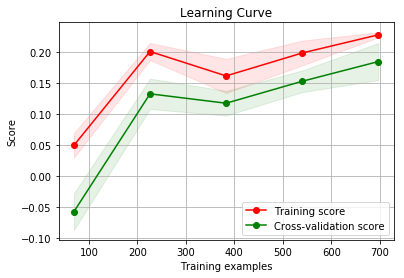

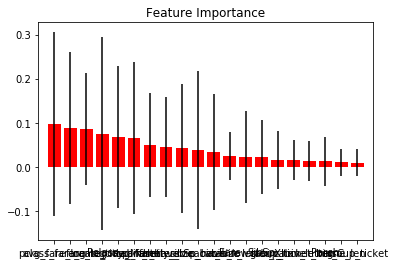

In [692]:
skplt.estimators.plot_learning_curve(age_model,x_train_age, y_train_age) #学习曲线
skplt.estimators.plot_feature_importances(age_model, feature_names=x_train_age.columns) #特征重要度曲线
plt.show()

In [693]:
concat_data_tmp['sex_child']=np.where(concat_data_tmp['Age']<16,1,0) #增加一个小孩分类
concat_data_tmp['sex_old']=np.where(concat_data_tmp['Age']>55,1,0) #增加一个老人分类

In [694]:
drop_col_list=['PassengerId','Name','Ticket','Cabin']
concat_data_tmp.drop(drop_col_list,inplace=True,axis=1) #删除部分变量
concat_data_tmp.head(10)

,Age,Fare,Parch,Pclass,SibSp,Survived,group_ticket,avg_fare,avg_fare_log,fare_log,name_len,pclass_fare_category,family_size,parch_have,sibSp_have,family_have,family_size_bins,ticket_isdigit,group_ticket_bins,cabin_have,cabin_size,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,name_title_Master,name_title_Mr,name_title_Mrs,name_title_Officer,ticket_letter_A,ticket_letter_A4,ticket_letter_A5,ticket_letter_AQ3,ticket_letter_AQ4,ticket_letter_AS,ticket_letter_C,ticket_letter_CA,ticket_letter_CASOTON,ticket_letter_FC,ticket_letter_FCC,ticket_letter_Fa,ticket_letter_LINE,ticket_letter_LP,ticket_letter_PC,ticket_letter_PP,ticket_letter_PPP,ticket_letter_SC,ticket_letter_SCA3,ticket_letter_SCA4,ticket_letter_SCAH,ticket_letter_SCOW,ticket_letter_SCPARIS,ticket_letter_SCParis,ticket_letter_SOC,ticket_letter_SOP,ticket_letter_SOPP,ticket_letter_SOTONO2,ticket_letter_SOTONOQ,ticket_letter_SP,ticket_letter_STONO,ticket_letter_STONO2,ticket_letter_STONOQ,ticket_letter_SWPP,ticket_letter_WC,ticket_letter_WEP,ticket_letter_X,cabin_letter_A,cabin_letter_B,cabin_letter_C,cabin_letter_D,cabin_letter_E,cabin_letter_F,cabin_letter_G,cabin_letter_T,cabin_letter_X,cabin_letter_bin_cabin_high,cabin_letter_bin_cabin_low,cabin_letter_bin_cabin_midd,sex_child,sex_old
0,22.0,7.25,0,3,1,0.0,1,7.25,1.98,1.98,20,5,1,0,1,1,1,0,1,1,0.0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,38.0,71.28,0,1,1,1.0,2,35.64,3.57,4.27,45,0,1,0,1,1,1,0,2,0,2.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,26.0,7.92,0,3,0,1.0,1,7.92,2.07,2.07,20,4,0,0,0,0,0,0,1,1,0.0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,35.0,53.10,0,1,1,1.0,2,26.55,3.28,3.97,38,0,1,0,1,1,1,1,2,0,2.0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,35.0,8.05,0,3,0,0.0,1,8.05,2.09,2.09,21,4,0,0,0,0,0,1,1,1,0.0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
5,29.0,8.46,0,3,0,0.0,1,8.46,2.14,2.14,14,4,0,0,0,0,0,1,1,1,0.0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
6,54.0,51.86,0,1,0,0.0,2,25.93,3.26,3.95,20,0,0,0,0,0,0,1,2,0,2.0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
7,2.0,21.07,1,3,3,0.0,5,4.21,1.44,3.05,27,4,4,1,1,1,3,1,4,1,0.0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0
8,27.0,11.13,2,3,0,1.0,3,3.71,1.31,2.41,43,4,2,1,0,1,2,1,3,1,0.0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
9,14.0,30.07,0,2,1,1.0,2,15.04,2.71,3.40,31,2,1,0,1,1,1,1,2,1,0.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0


In [697]:
x_train=concat_data_tmp[pd.notnull(concat_data_tmp['Survived'])].drop('Survived',axis=1) #删除部分变量
y_train=concat_data_tmp[pd.notnull(concat_data_tmp['Survived'])].Survived

x_test=concat_data_tmp[pd.isnull(concat_data_tmp['Survived'])].drop('Survived',axis=1) #删除部分变量
# test_data.drop('Survived',inplace=True,axis=1) #删除部分变量
print(x_train.shape,y_train.shape,x_test.shape)

(891, 80) (891,) (418, 80)


In [360]:
###### 划分训练集和测试集
# y=train_data.Survived
# x=train_data.drop('Survived',axis=1) #删除部分变量
# # print(x)
# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
# print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)
# data_desc(x)
# x.head(10)

(712, 41) (179, 41) (712,) (179,)


,colums,n_dtype,n_num,n_distinct,n_miss,pct_miss,n_min,n_max,n_mean,n_std,q_5,q_25,q_50,q_75,q_95,n_outliers,outliers_index
0,Age,float64,891,88,0,0.0,0.42,80.00,2.95e+01,13.23,6.00,22.00,29.00,36.00,54.00,1,[630]
1,name_len,int64,891,45,0,0.0,10.00,69.00,2.39e+01,8.22,14.00,18.00,22.00,27.00,41.00,3,"[307, 427, 556]"
2,pclass_fare_category,int64,891,6,0,0.0,0.00,5.00,2.80e+00,1.66,0.00,2.00,4.00,4.00,5.00,0,[]
3,ticket_numerical,int32,891,2,0,0.0,0.00,1.00,7.42e-01,0.44,0.00,0.00,1.00,1.00,1.00,0,[]
4,cabin_letter_C,int32,891,2,0,0.0,0.00,1.00,6.62e-02,0.25,0.00,0.00,0.00,0.00,1.00,0,[]
5,cabin_letter_B,int32,891,2,0,0.0,0.00,1.00,5.27e-02,0.22,0.00,0.00,0.00,0.00,1.00,0,[]
6,parch_have,int32,891,2,0,0.0,0.00,1.00,2.39e-01,0.43,0.00,0.00,0.00,0.00,1.00,0,[]
7,name_title_Mrs,int32,891,2,0,0.0,0.00,1.00,1.43e-01,0.35,0.00,0.00,0.00,0.00,1.00,0,[]
8,cabin_letter_bin_cabin_midd,int32,891,2,0,0.0,0.00,1.00,1.03e-01,0.30,0.00,0.00,0.00,0.00,1.00,0,[]
9,group_ticket_woe,float64,891,4,0,0.0,-0.63,1.21,-3.57e-02,0.69,-0.63,-0.52,-0.52,0.53,1.21,0,[]


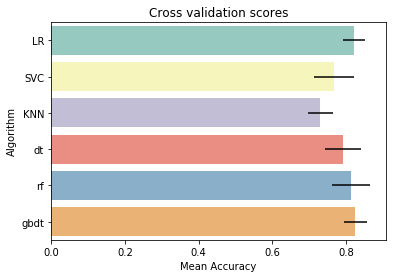

In [740]:
from sklearn.svm import SVC, LinearSVC

lr = LogisticRegression()
svc = SVC()
knn = KNeighborsClassifier(n_neighbors = 3)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=300,min_samples_leaf=4,class_weight={0:0.745,1:0.255})
gbdt = GradientBoostingClassifier(n_estimators=500,learning_rate=0.03,max_depth=3)
# xgbGBDT = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
clfs = [lr,svc,knn,dt,rf,gbdt]

kfold = 10
cv_results = []
for classifier in clfs :
    cv_results.append(cross_val_score(classifier, x_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["LR","SVC",'KNN','dt','rf','gbdt']})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [699]:
###### 决策树算法
#决策树算法调参
stsrt_dt=time.time()
KFold=StratifiedKFold(n_splits=10)
min_impurity_decrease={'min_impurity_decrease':np.linspace(0,0.5,51),
                       'criterion':['gini','entropy'],
                       'min_samples_leaf':[t for t in range(20,101,10)],
                       'max_depth':range(1,5)}
dt_model_cv=GridSearchCV(DecisionTreeClassifier(),min_impurity_decrease,cv=KFold,n_jobs=25, verbose=1,)
dt_model_cv.fit(x_train,y_train)
end_dt=time.time()
# print('best_params:{0}\nbest_score:{1}'.format(model.best_params_,model.best_score_))
# print('best_params:%s\nbest_score:%s\nComputing time:%.fs'%(dt_model.best_params_,dt_model.best_score_,end_dt-stsrt_dt))

print('best_params:%s\nbest_score:%.4f\n耗时：%.1f'%(dt_model_cv.best_params_,dt_model_cv.best_score_,end_dt-stsrt_dt))
# print(dt_model.cv_results_) #执行详细过程


Fitting 10 folds for each of 3672 candidates, totalling 36720 fits


[Parallel(n_jobs=25)]: Done 150 tasks      | elapsed:   26.9s
[Parallel(n_jobs=25)]: Done 640 tasks      | elapsed:   28.3s
[Parallel(n_jobs=25)]: Done 1340 tasks      | elapsed:   30.3s
[Parallel(n_jobs=25)]: Done 2240 tasks      | elapsed:   32.8s
[Parallel(n_jobs=25)]: Done 3340 tasks      | elapsed:   36.2s
[Parallel(n_jobs=25)]: Done 4640 tasks      | elapsed:   40.0s
[Parallel(n_jobs=25)]: Done 6140 tasks      | elapsed:   44.7s
[Parallel(n_jobs=25)]: Done 7840 tasks      | elapsed:   49.8s
[Parallel(n_jobs=25)]: Done 9740 tasks      | elapsed:   55.6s
[Parallel(n_jobs=25)]: Done 11840 tasks      | elapsed:  1.0min
[Parallel(n_jobs=25)]: Done 14140 tasks      | elapsed:  1.1min
[Parallel(n_jobs=25)]: Done 16640 tasks      | elapsed:  1.3min
[Parallel(n_jobs=25)]: Done 19340 tasks      | elapsed:  1.4min
[Parallel(n_jobs=25)]: Done 22240 tasks      | elapsed:  1.6min
[Parallel(n_jobs=25)]: Done 25340 tasks      | elapsed:  1.7min
[Parallel(n_jobs=25)]: Done 28640 tasks      | elap

best_params:{'criterion': 'entropy', 'max_depth': 3, 'min_impurity_decrease': 0.02, 'min_samples_leaf': 20}
best_score:0.8316
耗时：145.7


In [708]:
#决策树算法
# dt_model=DecisionTreeClassifier(max_depth=3,min_samples_leaf=30,
#                                 min_impurity_decrease=0.01,criterion='entropy').fit(x_train,y_train)
dt_model=dt_model_cv.best_estimator_.fit(x_train,y_train)

print('训练集准确率:{train_score:.4f}'.
      format(train_score=dt_model.score(x_train,y_train))) #训练集跟测试集准确率
print('训练集AUC:%.4f'%(metrics.roc_auc_score(y_train,dt_model.predict_proba(x_train)[:,1]))) #计算ROC值
print('训练集10折交叉验证准确性：%.4f'%(cross_val_score(dt_model,x_train,y_train,cv=10,scoring='accuracy').mean()))


importances=dt_model.feature_importances_   #变量重要性排序
indexs=np.argsort(importances)[::-1]
df_col=x_train.columns
print('-'*20+'变量重要性'+'-'*20)
for f in range(x_train.shape[1]):
    if importances[indexs[f]]>0:
        print(df_col[indexs[f]],':',importances[indexs[f]])
    
# ############绘制ROC曲线 方式一
# skplt.metrics.plot_roc_curve(y_train, dt_model.predict_proba(x_train),cmap='nipy_spectral',figsize=(16, 10))

############绘制ROC曲线 方式二
# fpr, tpr, thresholds = metrics.roc_curve(y_train, dt_model.predict_proba(x_train)[:,1])
# plt.figure(figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (auc(fpr, tpr)))  
# plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')  
# # plt.xlim([0, 1])  
# # plt.ylim([0, 1])  
# plt.xlabel('False Positive Rate(误杀率)')  
# plt.ylabel('True Positive Rate（准确率）')  
# plt.title('Roc Curves')  
# plt.legend(loc="lower right")  
# plt.show()  

# skplt.estimators.plot_learning_curve(dt_model,x_train,y_train,figsize=(16,10)) #学习曲线2
# skplt.metrics.plot_ks_statistic(y_train,dt_model.predict_proba(x_train),figsize=(16,10)) #ks曲线
pd.value_counts(np.equal(dt_model.predict(x_train),y_train))

训练集准确率:0.8316
训练集AUC:0.8706
训练集10折交叉验证准确性：0.8316
--------------------变量重要性--------------------
name_title_Mr : 0.636490125066548
pclass_fare_category : 0.1856685157667802
group_ticket_bins : 0.10235746429419346
avg_fare : 0.07548389487247834


True     741
False    150
Name: Survived, dtype: int64

In [710]:
#决策树可视化
data_feature_name=x_train.columns
dot_tree = export_graphviz(dt_model,out_file=None,feature_names=data_feature_name,
                           class_names="Survived",
                           filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_tree)
img = Image(graph.create_png())
graph.write_png("./泰坦尼克/dt_model.png")

True

In [409]:
#随机森林算法调参
KFold=StratifiedKFold(n_splits=10)
stsrt_dt=time.time()
min_impurity_decrease={'n_estimators':np.linspace(1,100,51).astype('int'),
                       'min_impurity_decrease':np.linspace(0,0.5,51),
                       'criterion':['gini','entropy'],
                       'min_samples_leaf':[t for t in range(20,101,10)],
                       'max_depth':range(1,5)}
rf_model_cv=GridSearchCV(RandomForestClassifier(),min_impurity_decrease,cv=KFold,n_jobs=-1, verbose=1)
rf_model_cv.fit(x_train,y_train)

end_dt=time.time()
print('best_params:%s\nbest_score:%.4f\n耗时：%.1f'%(rf_model_cv.best_params_,rf_model_cv.best_score_,end_dt-stsrt_dt))
print(rf_model.cv_results_)

Fitting 10 folds for each of 187272 candidates, totalling 1872720 fits


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 1536 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2430 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3934 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 5926 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 8308 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 10981 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 13661 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 16541 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 19804 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 23587 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 27570 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 32343 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 37061 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 41209 tasks      | el

best_params:{'criterion': 'gini', 'max_depth': 4, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 20, 'n_estimators': 90}
best_score:0.8272
耗时：66803.8


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



训练集准确率:0.8316
训练集AUC:0.8706
训练集10折交叉验证准确性：0.8316
--------------------变量重要性--------------------
Sex_female ： 0.16127900243521764
name_title_Mr ： 0.1599406686271071
Sex_male ： 0.12710723940292581
name_title_Mrs ： 0.11259291116093839
avg_fare_log ： 0.048987157791679045
pclass_fare_category ： 0.04314387470645034
Fare ： 0.03557364800565284
fare_log ： 0.02693133780026136
cabin_size ： 0.023774278164154818
name_len ： 0.023728853800230723
cabin_have ： 0.023388506617147635
avg_fare ： 0.02335190829879315
group_ticket ： 0.022216167535597978
Pclass ： 0.02198785550320568
cabin_letter_X ： 0.020024024344986926
group_ticket_bins ： 0.01963442960818521
Age ： 0.017691693794702448
cabin_letter_bin_cabin_low ： 0.01677408409033384
family_size ： 0.01509187218745947
family_size_bins ： 0.01215399320579893
cabin_letter_bin_cabin_high ： 0.010776680878521377
sex_child ： 0.008884314999697943
Embarked_S ： 0.004467381690689407
family_have ： 0.0037948931960755366
SibSp ： 0.003150410303367909
parch_have ： 0.00289014459

True     742
False    149
Name: Survived, dtype: int64

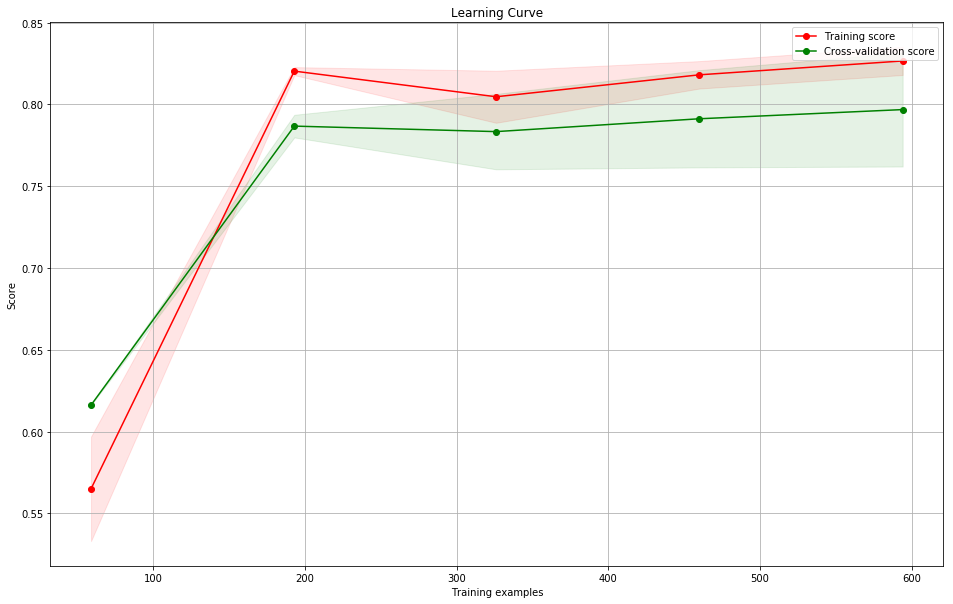

In [718]:
# 随机森林算法
rf_model=RandomForestClassifier(n_estimators=90,oob_score=True,criterion='gini',min_samples_leaf=20,
#                                 max_features=0.6,
                                max_depth=4).fit(x_train,y_train)
# rf_model=rf_model_cv.best_estimator_.fit(x_train,y_train)

print('训练集准确率:{train_score:.4f}'.
      format(train_score=dt_model.score(x_train,y_train))) #训练集跟测试集准确率
print('训练集AUC:%.4f'%(metrics.roc_auc_score(y_train,dt_model.predict_proba(x_train)[:,1]))) #计算ROC值
print('训练集10折交叉验证准确性：%.4f'%(cross_val_score(dt_model,x_train,y_train,cv=10,scoring='accuracy').mean()))


# train_score_list=[]
# test_score_list=[]
# for i in np.linspace(0.1,1,10).tolist()+['auto']:
#     rf_model=RandomForestClassifier(n_estimators=40,oob_score=True,criterion='gini',min_samples_leaf=20,
#                                 max_features=i,max_depth=4)
#     rf_model.fit(x_train,y_train)
# #     train_score_list.append(rf_model.score(x_train,y_train))
# #     test_score_list.append(rf_model.score(x_test,y_test))
#     train_score_list.append(cross_val_score(rf_model,x_train,y_train,cv=10,scoring='accuracy').mean())
#     test_score_list.append(cross_val_score(rf_model,x_test,y_test,cv=10,scoring='accuracy').mean())

# plt.figure(figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(np.linspace(0.1,1,10).tolist()+['auto'],train_score_list, 'o-', color='r', label='trains_score')
# plt.plot(np.linspace(0.1,1,10).tolist()+['auto'],test_score_list,'o-', color='b', label='test_score')
# plt.legend(loc='best')
# plt.show


print('-'*20+'变量重要性'+'-'*20)
importances=rf_model.feature_importances_   #变量重要性排序
indexs=np.argsort(importances)[::-1]
df_col=x_train.columns
for f in range(x_train.shape[1]):
    print(df_col[indexs[f]],'：',importances[indexs[f]])
    

skplt.estimators.plot_learning_curve(rf_model,x_train,y_train,figsize=(16,10)) #学习曲线2
# skplt.metrics.plot_roc_curve(y_test,rf_model.predict_proba(x_test),cmap='nipy_spectral',figsize=(16, 10)) #roc曲线
# skplt.metrics.plot_ks_statistic(y_train,rf_model.predict_proba(x_train),figsize=(16,10)) #ks曲线
# plt.show()
pd.value_counts(np.equal(rf_model.predict(x_train),y_train))

In [109]:
#########GBDT算法调参
min_impurity_decrease={'n_estimators':np.linspace(2,200,100).astype('int'),
                       'learning_rate':np.linspace(0.01,0.5,50),
                       'subsample':np.linspace(0.5,0.8,11),
                       'max_depth':range(1,5)}
gbdt_model_cv=GridSearchCV(GradientBoostingClassifier(),min_impurity_decrease,cv=5,n_jobs=-1, verbose=1)
gbdt_model_cv.fit(x_train,y_train)
gbdt_model_cv.best_params_

Fitting 5 folds for each of 220000 candidates, totalling 1100000 fits


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1764 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 3166 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4216 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5575 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 8389 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 9039 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 9789 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 10639 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 13638 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 14883 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 16033 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 19134 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 20484 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 21934 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 26868 tasks      | el

{'learning_rate': 0.24000000000000002,
 'max_depth': 3,
 'n_estimators': 16,
 'subsample': 0.62}

训练集准确率:0.8462
训练集AUC:0.9124
训练集10折交叉验证准确性：0.8372


True     787
False    104
Name: Survived, dtype: int64

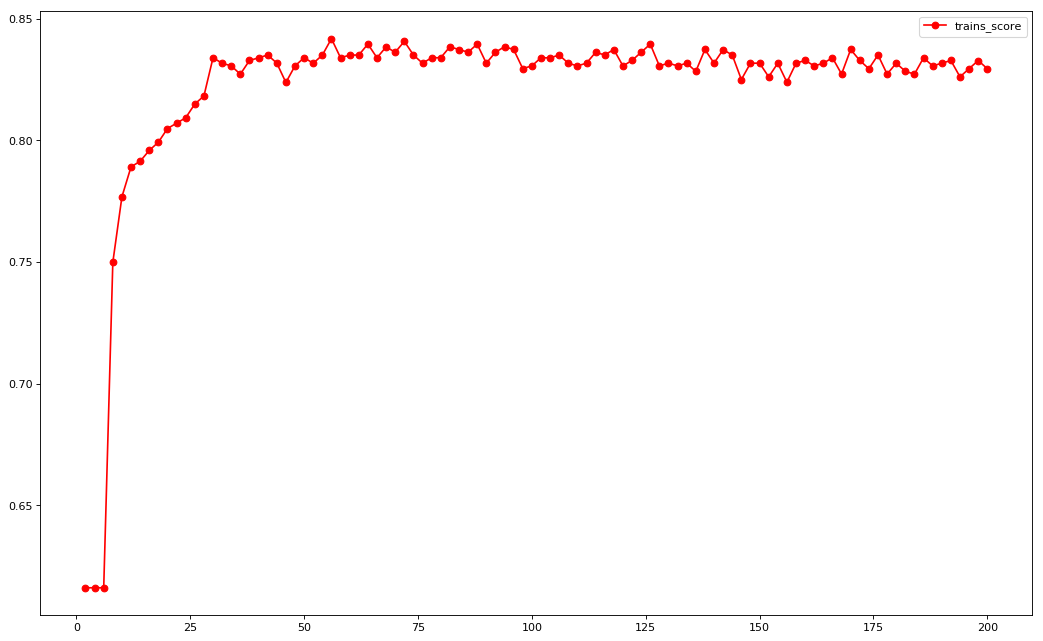

In [717]:
#########GBDT算法
gbdt_model = GradientBoostingClassifier(n_estimators=40,learning_rate=0.03,max_depth=3,subsample=0.56).fit(x_train,y_train)
# gbdt_model=gbdt_model_cv.best_estimator_.fit(x_train,y_train)

print('训练集准确率:{train_score:.4f}'.
      format(train_score=gbdt_model.score(x_train,y_train))) #训练集跟测试集准确率
print('训练集AUC:%.4f'%(metrics.roc_auc_score(y_train,gbdt_model.predict_proba(x_train)[:,1]))) #计算ROC值
print('训练集10折交叉验证准确性：%.4f'%(cross_val_score(gbdt_model,x_train,y_train,cv=10,scoring='accuracy').mean()))



train_score_list=[]
test_score_list=[]
for i in np.linspace(2,200,100).astype('int'):
    gbdt_model = GradientBoostingClassifier(n_estimators=i,learning_rate=0.03,max_depth=3,subsample=0.56)
    gbdt_model.fit(x_train,y_train)
    train_score_list.append(cross_val_score(gbdt_model,x_train,y_train,cv=10,scoring='accuracy').mean())
#     test_score_list.append(cross_val_score(gbdt_model,x_test,y_test,cv=10,scoring='accuracy').mean())

plt.figure(figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.linspace(2,200,100).astype('int'),train_score_list, 'o-', color='r', label='trains_score')
# plt.plot(np.linspace(2,200,100).astype('int'),test_score_list,'o-', color='b', label='test_score')
plt.legend(loc='best')
plt.show

# print('-'*20+'变量重要性'+'-'*20)
# importances=gbdt_model.feature_importances_   #变量重要性排序
# indexs=np.argsort(importances)[::-1]
# df_col=x_train.columns
# for f in range(x_train.shape[1]):
#     print(df_col[indexs[f]],'：',importances[indexs[f]])

# plot_learning_curve(gbdt_model,x_train,y_train,title='lr_model') #学习曲线1
# skplt.estimators.plot_learning_curve(gbdt_model,x_train,y_train,figsize=(16,10),title='lr_model') #学习曲线2
# skplt.metrics.plot_roc_curve(y_test,gbdt_model.predict_proba(x_test),cmap='nipy_spectral',figsize=(16, 10)) #roc曲线
# skplt.metrics.plot_ks_statistic(y_train,gbdt_model.predict_proba(x_train),figsize=(16,10)) #ks曲线
# plt.show()
pd.value_counts(np.equal(gbdt_model.predict(x_train),y_train))

In [714]:
#########xgboost算法调参
KFold=StratifiedKFold(n_splits=10)
param_grid = {
    'n_estimators': [80,100,120,140,160,180,200],
    'learning_rate': [0.01,0.03,0.1,0.3],
    'subsample':[0.5,0.8,1],
    'max_depth':[2,3,4,5]
}
xgb_model_cv = GridSearchCV(xgb.XGBClassifier(), param_grid=param_grid,cv=KFold, scoring='accuracy',n_jobs=-1, verbose=1)
xgb_model_cv.fit(x_train, y_train)
xgb_model_cv.best_params_

Fitting 10 folds for each of 336 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed: 11.0min finished


{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.5}

In [736]:
# xgb_model=xgb.XGBClassifier(n_estimators=120,learning_rate=0.1,max_depth=4,subsample=0.8).fit(x_train,y_train)
xgb_model=xgb_model_cv.best_estimator_.fit(x_train,y_train)

print('训练集准确率:{train_score:.4f}'.
      format(train_score=xgb_model.score(x_train,y_train))) #训练集跟测试集准确率
print('训练集AUC:%.4f'%(metrics.roc_auc_score(y_train,xgb_model.predict_proba(x_train)[:,1]))) #计算ROC值
print('训练集10折交叉验证准确性：%.4f'%(cross_val_score(xgb_model,x_train,y_train,cv=10,scoring='accuracy').mean()))

pd.value_counts(np.equal(xgb_model.predict(x_train),y_train))


训练集准确率:0.8709
训练集AUC:0.9280
训练集10折交叉验证准确性：0.8429


True     776
False    115
Name: Survived, dtype: int64

array([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 0., 0., 0., 0.

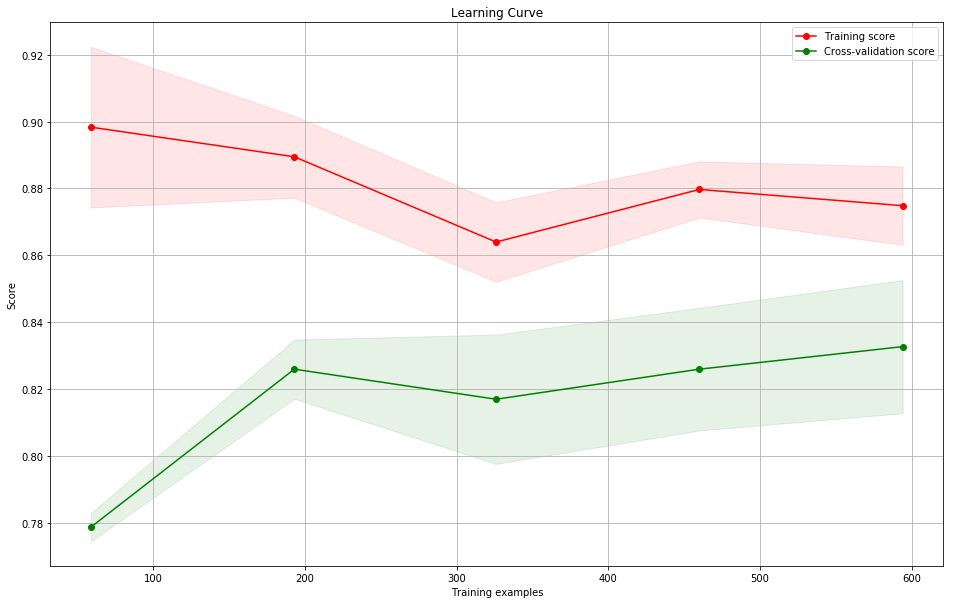

In [735]:
skplt.estimators.plot_learning_curve(xgb_model,x_train,y_train,figsize=(16,10)) #学习曲线2

submission = pd.DataFrame({ 'PassengerId':validation_data['PassengerId'],
                            'Survived':xgb_model.predict(x_test).astype(int) })
submission.to_csv("./泰坦尼克/submission_xgb.csv", index=False,encoding='utf8')
xgb_model.predict(x_train)

In [731]:
from sklearn.model_selection import KFold

def get_stacking(clf, x_train, y_train, x_test, n_folds=10):
    """
    这个函数是stacking的核心，使用交叉验证的方法得到次级训练集
    x_train, y_train, x_test 的值应该为numpy里面的数组类型 numpy.ndarray .
    如果输入为pandas的DataFrame类型则会把报错"""
    train_num, test_num = x_train.shape[0], x_test.shape[0]
    second_level_train_set = np.zeros((train_num,)) #用于存储clf预测x_train的结果
    second_level_test_set = np.zeros((test_num,)) #用于存储clf预测x_test的概率（10折求均值）
    test_nfolds_sets = np.zeros((test_num, n_folds)) #存储lf预测x_test的10折结果

    kf = KFold(n_splits=n_folds)
    x_train,y_train,x_test=x_train.values,y_train.values,x_test.values #将datafrema处理成array格式

    for i,(train_index, test_index) in enumerate(kf.split(x_train)):
        x_tra, y_tra = x_train[train_index], y_train[train_index]
        x_tst, y_tst = x_train[test_index], y_train[test_index]
        clf.fit(x_tra, y_tra)
        second_level_train_set[test_index] = clf.predict(x_tst) #累计存x_train[test_index]的计算结果
        test_nfolds_sets[:,i] = clf.predict(x_test) #存储每次10折循环的x_test结果

    second_level_test_set[:] = test_nfolds_sets.mean(axis=1)
    return second_level_train_set, second_level_test_set


train_sets = []
test_sets = []

for clf in [dt_model, rf_model, gbdt_model, xgb_model]:
    train_set, test_set = get_stacking(clf, x_train, y_train, x_test)
    train_sets.append(train_set)
    test_sets.append(test_set)
 


meta_train= np.concatenate([result_set.reshape(-1,1) for result_set in train_sets], axis=1)
meta_test = np.concatenate([y_test_set.reshape(-1,1) for y_test_set in test_sets], axis=1)



#使用逻辑回归作为我们的次级分类器
model_fin = LogisticRegression(C=1.0,penalty='l1',tol=1e-6)
model_fin.fit(meta_train, y_train)
df_predict = model_fin.predict(meta_test)

print('训练集准确率:{train_score:.4f};'.format(train_score=model_fin.score(meta_train, y_train))) #训练集跟测试
print('AUC:%.4f'%(metrics.roc_auc_score(y_train,model_fin.predict_proba(meta_train)[:,1]))) #计算ROC值



print('-'*20+'变量系数'+'-'*20)
model_list=['dt_model', 'rf_model', 'gbdt_model', 'xgb_model']
for i in range(meta_train.shape[1]): #变量系数
    print(model_list[i],':',model_fin.coef_.tolist()[0][i])


pd.value_counts(np.equal(model_fin.predict(meta_train),y_train))
# pd.value_counts(np.equal(df_predict,y_test))


训练集准确率:0.8361;
AUC:0.8401
--------------------变量系数--------------------
dt_model : 1.4069141017850768
rf_model : -0.09019054832833748
gbdt_model : 0.8522037642247734
xgb_model : 1.2423546016926814


True     745
False    146
Name: Survived, dtype: int64

In [737]:
test_data_tmp_set=[]
for clf in [dt_model, rf_model, gbdt_model, xgb_model]:
    test_data_tmp_set.append(clf.predict(test_data))

meta_test_tmp = np.concatenate([result_set.reshape(-1,1) for result_set in test_data_tmp_set], axis=1)
submission = pd.DataFrame({ 'PassengerId':validation_data['PassengerId'],
                            'Survived': model_fin.predict(meta_test_tmp).astype(int) })
submission.to_csv("./泰坦尼克/submission.csv", index=False,encoding='utf8')


In [85]:
####逻辑回归算法

lr_model=LogisticRegression(C=1.0,penalty='l1',tol=1e-6)
lr_model.fit(x_train,y_train)

print('训练集准确率:{train_score:.4f};\n测试集准确率:{test_score:.4f}'.
      format(train_score=lr_model.score(x_train,y_train),test_score=lr_model.score(x_test,y_test))) #训练集跟测试集准确率


print('-'*20+'变量系数'+'-'*20)
for i in range(1,x_train.shape[1],1): #变量系数
    print(x_train.columns.tolist()[i],':',lr_model.coef_.tolist()[0][i])
# [[x_train.columns.tolist()[i],lr_model.coef_.tolist()[0][i]] for i in range(1,x_train.shape[1],1)] #变量系数


# plot_learning_curve(lr_model,x_train,y_train,title='lr_model') #学习曲线1
skplt.estimators.plot_learning_curve(lr_model,x_train,y_train,figsize=(16,10),title='lr_model') #学习曲线2
skplt.metrics.plot_roc_curve(y_test,lr_model.predict_proba(x_test),cmap='nipy_spectral',figsize=(16, 10)) #roc曲线
skplt.metrics.plot_ks_statistic(y_train,rf_model.predict_proba(x_train),figsize=(16,10)) #ks曲线
plt.show()

In [55]:
import numpy as np
from sklearn.model_selection import KFold
def get_stacking(clf, x_train, y_train, x_test, n_folds=10):
    """
    这个函数是stacking的核心，使用交叉验证的方法得到次级训练集
    x_train, y_train, x_test 的值应该为numpy里面的数组类型 numpy.ndarray .
    如果输入为pandas的DataFrame类型则会把报错"""
    train_num, test_num = x_train.shape[0], x_test.shape[0]
    second_level_train_set = np.zeros((train_num,))
    second_level_test_set = np.zeros((test_num,))
    test_nfolds_sets = np.zeros((test_num, n_folds))
    kf = KFold(n_splits=n_folds)

    for i,(train_index, test_index) in enumerate(kf.split(x_train)):
        x_tra, y_tra = x_train[train_index], y_train[train_index]
        x_tst, y_tst =  x_train[test_index], y_train[test_index]

        clf.fit(x_tra, y_tra)

        second_level_train_set[test_index] = clf.predict(x_tst)
        test_nfolds_sets[:,i] = clf.predict(x_test)

    second_level_test_set[:] = test_nfolds_sets.mean(axis=1)
    return second_level_train_set, second_level_test_set



#我们这里使用5个分类算法，为了体现stacking的思想，就不加参数了
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

rf_model = RandomForestClassifier()
adb_model = AdaBoostClassifier()
gdbc_model = GradientBoostingClassifier()
et_model = ExtraTreesClassifier()
svc_model = SVC()

#在这里我们使用train_test_split来人为的制造一些数据
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()
train_x, test_x, train_y, test_y = train_test_split(iris.data, iris.target, test_size=0.2)

train_sets = []
test_sets = []
for clf in [rf_model, adb_model, gdbc_model, et_model, svc_model]:
    train_set, test_set = get_stacking(clf, train_x, train_y, test_x)
    train_sets.append(train_set)
    test_sets.append(test_set)
    

meta_train = np.concatenate([result_set.reshape(-1,1) for result_set in train_sets], axis=1)
meta_test = np.concatenate([y_test_set.reshape(-1,1) for y_test_set in test_sets], axis=1)
# print(meta_train)

#使用决策树作为我们的次级分类器
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model.fit(meta_train, train_y)
df_predict = dt_model.predict(meta_test)

print(df_predict)
print(iris)

[2 0 0 1 2 2 0 0 2 0 1 2 2 2 0 2 1 2 0 2 1 0 1 2 2 1 2 1 1 2]
{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
 

In [168]:
train_data[train_data['Cabin'].apply(lambda x:True if str(x).find(' ')>=0 else False)]
# x=[i for i in range(0,len(train_data.sort_values(['Ticket'])))]
# plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
# t=plt.scatter('Ticket',x,data=train_data.sort_values(['Ticket']),c='Survived')

# plt.legend(fontsize=12)
# plt.legend(loc='best') #图例
# plt.show()
train_data.sort_values(['Name'])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,new_tag
845,846,0,3,"Abbing, Mr. Anthony",male,42.00,0,0,C.A. 5547,7.5500,NaN,S,0
746,747,0,3,"Abbott, Mr. Rossmore Edward",male,16.00,1,1,C.A. 2673,20.2500,NaN,S,0
279,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.00,1,1,C.A. 2673,20.2500,NaN,S,1
308,309,0,2,"Abelson, Mr. Samuel",male,30.00,1,0,P/PP 3381,24.0000,NaN,C,0
874,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.00,1,0,P/PP 3381,24.0000,NaN,C,1
365,366,0,3,"Adahl, Mr. Mauritz Nils Martin",male,30.00,0,0,C 7076,7.2500,NaN,S,0
401,402,0,3,"Adams, Mr. John",male,26.00,0,0,341826,8.0500,NaN,S,0
40,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.00,1,0,7546,9.4750,NaN,S,0
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.00,0,1,392091,9.3500,NaN,S,1
207,208,1,3,"Albimona, Mr. Nassef Cassem",male,26.00,0,0,2699,18.7875,NaN,C,1


In [123]:
test=pd.read_csv('./file/train.csv')
pd.set_option('display.max_columns',100) ##设置显示列数
pd.set_option('precision',4) ##设置小数点位数
pd.set_option('max_colwidth',1500) ##设置列长度
# bins=input_data['Age'].min().tolist()+[0,10,18,27,48,124,135]+input_data['Age'].max().tolist()
# bins=10
# input_data['Age'].cumsum(axis=0)

# input_data.drop(['Name','Ticket','Cabin'],inplace=True,axis=1) #删除部分变量

# print(var_freq(input_data,'Embarked',"Survived",[-999,0,8,24,999]))

# sc.var_filter(input_data, y="Survived")
# bins = sc.woebin(input_data, y="Survived",x='Embarked')
# print(bins)
# breaks_adj = sc.woebin_adj(input_data, 'Survived', bins=[0,10,20,60],adj_all_var=False) 
# sc.woebin_plot(bins)


# binning adjustment
# # adjust breaks interactively
# breaks_adj = sc.woebin_adj(dt_s, "creditability", bins) 
# # or specify breaks manually
# breaks_adj = {
#     'Age': [26, 35, 40]
# }
# bins_adj = sc.woebin(input_data, y="Survived", breaks_list=breaks_adj)
# print(bins_adj)

def var_freq_2(input_data,var1,var2,bins):
    labels=[i for i in range(0,bins)]
    cut_1=pd.cut(input_data[var1].tolist(),bins=bins).astype(str) #变量等宽分组十等份
    cut_2=pd.cut(input_data[var1].tolist(),bins=bins,labels=labels).astype(str) #变量等宽分组十等份并且记录顺序
    cut=[j+'_'+i for i,j in zip(cut_1,cut_2)]
    cat = pd.DataFrame({'%s_gap'%var1: cut})
    input_data = pd.merge(input_data,cat,left_index=True,right_index=True) #分组变量与原表组合
# input_data=input_data[~input_data[var1].isnull()] #删掉空值

    input_data_pivot_1=pd.pivot_table(input_data[input_data['Survived']==1],index=['%s_gap'%var1],values=["PassengerId"],columns=[var2],aggfunc=[len])
    input_data_pivot_2=pd.pivot_table(input_data,index=['%s_gap'%var1],values=["PassengerId"],columns=[var2],aggfunc=[len])
    input_data_pivot=pd.merge(input_data_pivot_1,input_data_pivot_2,left_index=True,right_index=True)
    var_name=input_data_pivot.columns.values.tolist()
    
    print(var_name)
#     for i in range(0,len(var_name)):
#         input_data_pivot[var_name[i]]=round(input_data_pivot[var_name[i]]*100/(input_data_pivot[var_name[i]].sum()),2)
#     input_data_pivot.fillna(0,inplace=True)
        
#     overlap = Overlap(width=1200, height=600)
#     for i in  range(0,len(var_name)):
#         line_i=Line()
#         line_i.add(str(var_name[i][2]),input_data_pivot.index,input_data_pivot[var_name[i]],is_lable_show=True,is_smooth=True,is_datazoom_show=True,
#                    datazoom_range=[0,100])
#         overlap.add(line_i)
#     overlap.render()
    return input_data_pivot 

var_freq_2(test,'Pclass','Sex',10)

[('len_x', 'PassengerId', 'female'), ('len_x', 'PassengerId', 'male'), ('len_y', 'PassengerId', 'female'), ('len_y', 'PassengerId', 'male')]


len_x            len_y     
               PassengerId      PassengerId     
Sex                 female male      female male
Pclass_gap                                      
0_(0.998, 1.2]          91   45          94  122
4_(1.8, 2.0]            70   17          76  108
9_(2.8, 3.0]            72   47         144  347

In [177]:
a=pd.pivot_table(test,index=['Pclass'],values=["PassengerId"],columns=['Sex'],aggfunc=[len])
b=pd.pivot_table(test[test['']==1],index=['Pclass'],values=["PassengerId"],columns=['Sex'],aggfunc=[len])
pd.merge(a,b,left_index=True,right_index=True)



len_x            len_y     
       PassengerId      PassengerId     
Sex         female male      female male
Pclass                                  
1               94  122          91   45
2               76  108          70   17
3              144  347          72   47

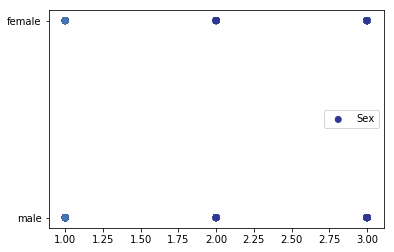

In [160]:
plt.figure()
plt.scatter(test['Pclass'],test['Sex'],c=['#313695', '#4575b4'])
plt.legend(loc='best')
plt.show()

# scatter=Scatter()
# z=list(test['Survived'])
# scatter.add('',x_axis =test['Pclass'],y_axis=test['Sex'],extra_data=z,
#             is_visualmap=True,
#             visual_range_color = ['#313695', '#4575b4'],
#             label_color=['#4575b4', '#313695']
#            )
# scatter.render()


In [202]:
#数据清洗

data.loc[data['Embarked'].isnull(),'Embarked']=data['Embarked'].value_counts(ascending=False).index[0] #众数填补
# data.Cabin=data.Cabin.apply(lambda x:np.str(x)[0:1])
data['Cabin_new']=np.where(data['Cabin'].notnull(),'Y','N')
data.Cabin=data.Cabin.apply(lambda x:np.str(x)[0:1] if pd.notnull(x) else x) 
for val in data.columns.tolist():
    var_freq(data,val,'Survived',10)

data=pd.get_dummies(data,columns=['Cabin'],dummy_na=True,dtype=int)
data=pd.get_dummies(data,columns=['Sex','Embarked','Cabin_new'],dtype=int)


# var_astype(data,'Embarked')
# var_astype(data,'Sex')
# var_astype(data,'new_sex')
# var_astype(data,'Cabin')

data.drop(['Name','Ticket','PassengerId'],inplace=True,axis=1) #删除部分变量
# var_freq(data,'Embarked','Survived')
# data.head(10)
# data['Embarked'].value_counts(ascending=False).index[0]
data.head(10)

# var_freq(data,'Cabin','Survived',10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_nan,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin_new_N,Cabin_new_Y
0,0,3,22.0,1,0,7.2500,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0
1,1,1,38.0,1,0,71.2833,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1
2,1,3,26.0,0,0,7.9250,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
3,1,1,35.0,1,0,53.1000,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
4,0,3,35.0,0,0,8.0500,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0
5,0,3,NaN,0,0,8.4583,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0
6,0,1,54.0,0,0,51.8625,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1
7,0,3,2.0,3,1,21.0750,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0
8,1,3,27.0,0,2,11.1333,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
9,1,2,14.0,1,0,30.0708,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0


In [203]:
x_var=[i for i in data.columns.tolist() if i not in ['Survived','Age','PassengerId']]
x_train_age=data[data['Age'].notnull()][x_var]
y_train_age=data[data['Age'].notnull()]['Age']
x_test_age=data[data['Age'].isnull()][x_var]
age_model=RandomForestRegressor()
age_model.fit(x_train_age,y_train_age)
data.loc[data['Age'].isnull(),'Age']=np.round(age_model.predict(x_test_age),0)

In [204]:
# data_desc(data)
# data.head(30)
importances=age_model.feature_importances_   #变量重要性排序
indexs=np.argsort(importances)[::-1]
df_col=x_train_age.columns
for f in range(x_train_age.shape[1]):
    print(df_col[indexs[f]],'   ',importances[indexs[f]])
age_model.score(x_train_age,y_train_age)

Fare     0.32163006686276174
Parch     0.1793620408445097
Pclass     0.17409636375518225
SibSp     0.1310426490192205
Sex_female     0.030039321628909026
Embarked_C     0.02310035789674122
Sex_male     0.02117404583045674
Embarked_S     0.019552228330890986
Embarked_Q     0.016726138755467853
Cabin_D     0.013942771780354624
Cabin_C     0.012891813743349152
Cabin_B     0.012352912340144323
Cabin_A     0.011663427600769546
Cabin_E     0.007878098940619655
Cabin_nan     0.00714281098035942
Cabin_new_N     0.007069190366537631
Cabin_new_Y     0.00624834247016341
Cabin_F     0.0019758663118256995
Cabin_G     0.0011091885959478365
Cabin_T     0.0010023639457887067


0.6843689986984316

In [317]:
data['Sex_child']=np.where(data['Age']<16,1,0) #增加一个小孩分类
data['Sex_old']=np.where(data['Age']>55,1,0) #增加一个老人分类
data_desc(data)

# 对部分变量做标准化处理
scaler=preprocessing.StandardScaler()
age_scale_param = scaler.fit(data[['Age']])
data['Age_scaled'] =scaler.fit_transform(data[['Age']],age_scale_param)
fare_scale_param = scaler.fit(data[['Fare']])
data['Fare_scaled']=scaler.fit_transform(data[['Fare']],fare_scale_param)
data.head(10)


,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_nan,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin_new_N,Cabin_new_Y,Sex_child,Sex_old,Age_scaled,Fare_scaled
0,0,3,22.0,1,0,7.2500,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,-0.5488,-0.5024
1,1,1,38.0,1,0,71.2833,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0.6078,0.7868
2,1,3,26.0,0,0,7.9250,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,-0.2596,-0.4889
3,1,1,35.0,1,0,53.1000,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0.3910,0.4207
4,0,3,35.0,0,0,8.0500,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0.3910,-0.4863
5,0,3,41.0,0,0,8.4583,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0.8247,-0.4781
6,0,1,54.0,0,0,51.8625,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1.7645,0.3958
7,0,3,2.0,3,1,21.0750,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,-1.9946,-0.2241
8,1,3,27.0,0,2,11.1333,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,-0.1874,-0.4243
9,1,2,14.0,1,0,30.0708,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,1,0,-1.1271,-0.0430


In [12]:
def decision_tree(i):
    start=time.clock()
    model=DecisionTreeClassifier(max_depth=4,max_leaf_nodes=200,min_samples_leaf=50,min_impurity_decrease=i)
    model=model.fit(x_train,y_train)
    tarin_score=model.score(x_train,y_train)
    test_score=model.score(x_test,y_test)
    return tarin_score,test_score

t=np.linspace(0,0.5,51)
model_score=[decision_tree(i) for i in t]
tarin_score=[s[0] for s in model_score]
test_score=[s[1] for s in model_score]

In [13]:
#决策树算法调参
stsrt_dt=time.time()
min_impurity_decrease={'min_impurity_decrease':np.linspace(0,0.5,51),
                       'criterion':['gini','entropy'],
                       'min_samples_leaf':[t for t in range(20,101,10)],
                       'max_depth':range(1,5)}
decision_tree_model=GridSearchCV(DecisionTreeClassifier(),min_impurity_decrease,cv=5)
decision_tree_model.fit(x_train,y_train)
decision_tree_model.best_params_
end_dt=time.time()
# print('best_params:{0}\nbest_score:{1}'.format(model.best_params_,model.best_score_))
print('best_params:%s\nbest_score:%s'%(decision_tree_model.best_params_,decision_tree_model.best_score_),end_dt-stsrt_dt)

best_params:{'criterion': 'gini', 'max_depth': 4, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 20}
best_score:0.7991573033707865 63.48089075088501


In [15]:
#决策树算法
decision_tree_model=DecisionTreeClassifier(max_depth=4,min_samples_leaf=20,min_impurity_decrease=0.01,criterion='gini')
decision_tree_model=decision_tree_model.fit(x_train,y_train)
print(decision_tree_model.score(x_train,y_train),decision_tree_model.score(x_test,y_test))
# np.unique(decision_tree_model.predict_proba(x_test)[:,0])
metrics.roc_auc_score(y_train,decision_tree_model.predict_proba(x_train)[:,1]) #计算ROC值

0.8117977528089888 0.8435754189944135


0.8556435394670688

In [16]:
#决策树可视化
data_feature_name=data.columns[2:]
dot_tree = export_graphviz(decision_tree_model,out_file=None,feature_names=data_feature_name,
                           class_names="Survived",
                           filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_tree)
img = Image(graph.create_png())
graph.write_png("decision_tree_model.png")

True

<module 'matplotlib.pyplot' from 'D:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

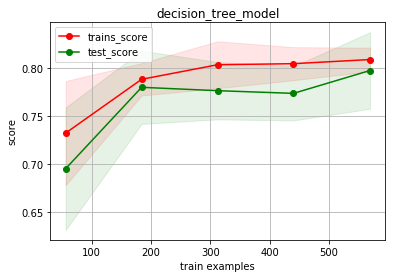

In [17]:
##决策树绘制学习曲线
plot_learning_curve(decision_tree_model,x_train,y_train,title='decision_tree_model')

In [18]:
#随机森林算法调参
stsrt_dt=time.time()
min_impurity_decrease={'n_estimators':np.linspace(1,100,51).astype('int'),
#                        'min_impurity_decrease':np.linspace(0,0.5,51),
                       'criterion':['gini','entropy'],
#                        'min_samples_leaf':[t for t in range(20,101,10)],
                       'max_depth':range(1,5)}
rf_model=GridSearchCV(RandomForestClassifier(),min_impurity_decrease,cv=5)
# rf_model=RandomForestClassifier(n_estimators=38,oob_score=True,criterion='gini',max_features=0.6)
rf_model.fit(x_train,y_train)
rf_model.best_params_
end_dt=time.time()
# print('best_params:{0}\nbest_score:{1}'.format(model.best_params_,model.best_score_))
print('best_params:%s\nbest_score:%s'%(rf_model.best_params_,rf_model.best_score_),end_dt-stsrt_dt)

best_params:{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 60}
best_score:0.8216292134831461 138.95579648017883


In [19]:
# 随机森林算法
rf_model=RandomForestClassifier(n_estimators=50,oob_score=True,criterion='gini',max_features=0.6,max_depth=4)
rf_model.fit(x_train,y_train)
print(rf_model.score(x_train,y_train),rf_model.score(x_test,y_test)) #训练集跟测试集准确率
importances=rf_model.feature_importances_   #变量重要性排序
indexs=np.argsort(importances)[::-1]
df_col=x_train.columns
for f in range(x_train.shape[1]):
    print(df_col[indexs[f]],'   ',importances[indexs[f]])
rf_model.predict_proba(x_train)[:,1]
metrics.roc_auc_score(y_train,rf_model.predict_proba(x_train)[:,1]) #计算ROC值
# rf_model.oob_score_

0.8441011235955056 0.8491620111731844
Sex_female     0.2670378431420702
Sex_male     0.24790548304427967
Pclass     0.13705935062702987
Age     0.10771948561842538
Fare     0.10694727583883529
SibSp     0.03791734681299107
Cabin_nan     0.03223575096359982
Sex_child     0.02051179925712695
Parch     0.01316193971230075
Embarked_S     0.009714339856737806
Sex_old     0.005754127231119591
Cabin_E     0.005258430270732708
Cabin_C     0.0026225953766857517
Embarked_Q     0.0017938276680700422
Cabin_B     0.001454821342404663
Embarked_C     0.001317520729087606
Cabin_D     0.0007568646894364549
Cabin_F     0.0007006752861411115
Cabin_G     0.00013052253292527324
Cabin_A     0.0
Cabin_T     0.0


0.896271158035864

<module 'matplotlib.pyplot' from 'D:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

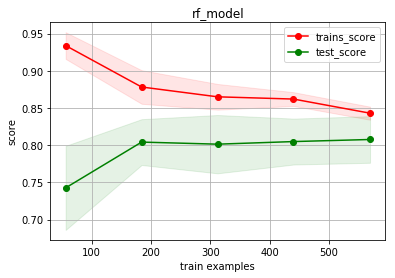

In [20]:
plot_learning_curve(rf_model,x_train,y_train,title='rf_model')

训练集准确率:0.8258;测试集准确率:0.7821
0.875476270053476
Age : 0.026337492567345442
SibSp : -0.3870475915638147
Parch : -0.12394322724601871
Fare : 0.0032257650056825207
Cabin_A : 0.0
Cabin_B : 0.0
Cabin_C : -0.36870789420036226
Cabin_D : 0.23456672438640028
Cabin_E : 0.6770803856857206
Cabin_F : 0.04675577081503096
Cabin_G : 0.0
Cabin_T : 0.0
Cabin_nan : 0.0
Sex_female : 2.647332613171083
Sex_male : 0.0
Embarked_C : 0.0
Embarked_Q : 0.23188086324532303
Embarked_S : -0.08800329851093502
Cabin_new_N : 0.0
Cabin_new_Y : 0.3856036839519205
Sex_child : 0.7349485730999401
Sex_old : 0.0
Age_scaled : -0.8883277969104475
Fare_scaled : 0.0


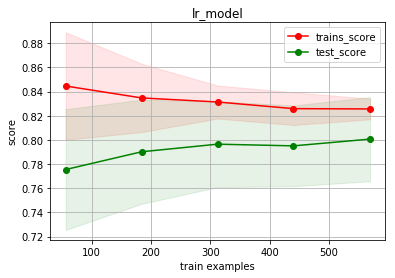

In [312]:
lr_model=LogisticRegression(C=1.0,penalty='l1',tol=1e-6)
lr_model.fit(x_train,y_train)
print('训练集准确率:{train_score:.4f};测试集准确率:{test_score:.4f}'.
      format(train_score=lr_model.score(x_train,y_train),test_score=lr_model.score(x_test,y_test))) #训练集跟测试集准确率

# print(lr_model.score(x_train,y_train),lr_model.score(x_test,y_test)) #训练集跟测试集准确率
plot_learning_curve(lr_model,x_train,y_train,title='lr_model')
print(metrics.roc_auc_score(y_train,lr_model.predict_proba(x_train)[:,1])) #ROC值

for i in range(1,x_train.shape[1],1): #变量系数
    print(x_train.columns.tolist()[i],':',lr_model.coef_.tolist()[0][i])
# [[x_train.columns.tolist()[i],lr_model.coef_.tolist()[0][i]] for i in range(1,x_train.shape[1],1)] #变量系数
#

In [ ]:
#增加二项式特征
# lr_model=polynomial_model(degree=2,penalty='l1')
# lr_model.fit(x_train,y_train)
# print(lr_model.score(x_train,y_train),lr_model.score(x_test,y_test)) #训练集跟测试集准确率
# plot_learning_curve(lr_model,x_train,y_train,title='lr_model')
# metrics.roc_auc_score(y_train,lr_model.predict_proba(x_train)[:,1])

In [22]:
x_test_result=pd.DataFrame({'decision_tree_model':decision_tree_model.predict(x_test),
                            'rf_model':rf_model.predict(x_test),
                            'lr_model':lr_model.predict(x_test)
                           })

x_test_result['all']=x_test_result['decision_tree_model']+x_test_result['rf_model']+x_test_result['lr_model']
x_test_result['all_1']=np.where(x_test_result['all']>1,1,0)
print(np.equal(x_test_result['all_1'],y_test).value_counts())
print(np.equal(decision_tree_model.predict(x_test),y_test).value_counts())
print(np.equal(rf_model.predict(x_test),y_test).value_counts())
print(np.equal(lr_model.predict(x_test),y_test).value_counts())

True     153
False     26
Name: all_1, dtype: int64
True     151
False     28
Name: Survived, dtype: int64
True     152
False     27
Name: Survived, dtype: int64
True     153
False     26
Name: Survived, dtype: int64


In [24]:
# abc=[]
# for i in range(x_tarin.shape[1]):
#     abc=cross_val_score(model,x_tarin,y_train,scoring='r2',cv=ShuffleSplit(len(x_tarin),3,.3))
#     print(abc)
#     abc.append((round(np.mean(abc),3),data_feature_name[i]))
#     abc.append(round(np.mean(abc,axis=0),3))


param_grid={'n_estimators': range(1,101,1)}
model_cv=GridSearchCV(RandomForestClassifier(criterion='gini',max_features=0.6,),
                      param_grid=param_grid,cv=5)
model_cv.fit(x_train,y_train)
# model_cv.grid_scores_


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(1, 101)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [25]:
from sklearn.model_selection import ShuffleSplit
cv=ShuffleSplit(n_splits=10)
# for train_index, test_index in cv.split(x_train):
#     print("train:", train_index, "test:", test_index)
cv=StratifiedKFold(n_splits=10)
# for train_index, test_index in cv.split(x_train,y_train):
#     print("train:", train_index, "test:", test_index)
model=DecisionTreeClassifier(max_depth=3,min_samples_leaf=30,min_impurity_decrease=0.01,max_leaf_nodes=200,)
model=model.fit(x_train,y_train)
plot_learning_curve(model,x_train,y_train,ylim=None,n_jobs=1,train_sizes=np.linspace(0.1,1,5),cv=10)
print(model.score(x_train,y_train),model.score(x_test,y_test))

TypeError: plot_learning_curve() missing 1 required positional argument: 'title'

                Ticket  Survived  counts
0               110152         1       3
1               110413         0       1
2               110413         1       2
3               110465         0       2
4               110564         1       1
5               110813         1       1
6               111240         0       1
7               111320         0       1
8               111361         1       2
9               111369         1       1
10              111426         1       1
11              111427         1       1
12              111428         1       1
13              112050         0       1
14              112052         0       1
15              112053         1       1
16              112058         0       1
17              112059         0       1
18              112277         1       1
19              112379         0       1
20              113028         0       1
21              113043         0       1
22              113050         0       1
23              

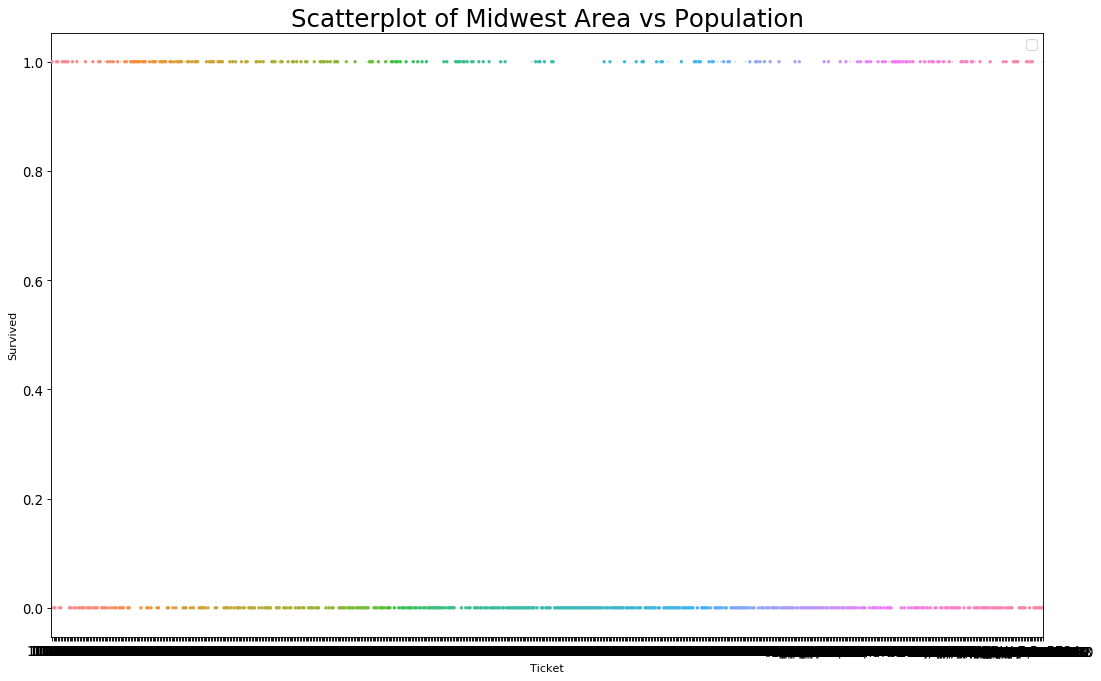

In [152]:
# midwest = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/midwest_filter.csv")

# Prepare Data
# Create as many colors as there are unique midwest['category']
Survived = np.unique(train_data['Survived'])
# colors = [plt.cm.tab10(i/float(len(Survived)-1)) for i in range(len(Survived))]

# print(colors)
# Draw Plot for Each Category
# plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')

# for i, category in enumerate(Survived):
#     plt.scatter('Age','Fare',
#                 data=data.loc[data.Survived==category, :],
#                 s=20, cmap=colors[i], label=str(category))

    
df_counts = train_data.groupby(['Ticket', 'Survived']).size().reset_index(name='counts')
print(df_counts)
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
# sns.stripplot(data.Age, data.Sex, jitter=0.25, size=8, ax=ax, linewidth=.5)
sns.stripplot(df_counts.Ticket, df_counts.Survived, size=df_counts.counts, ax=ax)
# Decorations
# plt.gca().set(xlim=(0.0, 1), ylim=(0, 900),
#               xlabel='Area', ylabel='Population')

plt.xticks(fontsize=12);
plt.yticks(fontsize=12)
plt.title("Scatterplot of Midwest Area vs Population", fontsize=22)
plt.legend(fontsize=12)    
plt.show()  

In [ ]:
data1=train_data[train_data['Survived']==1].groupby(['Sex','Pclass'])['PassengerId'].agg('count').reset_index()
data1['tag']='live'
data2=train_data.groupby(['Sex','Pclass'])['PassengerId'].agg('count').reset_index()
data2['tag']='sum'
px.scatter(pd.concat([data1,data2]),x='Sex',y='Pclass',color='tag',size='PassengerId')